## Домашнее задание №4
### Deadline - 14 November 23:59

Данное задание посвящено семантической сегментации. Ваша цель реализовать модель сегментации cпутниковых снимков на датасете [FloodNet Challenge](http://www.classic.grss-ieee.org/earthvision2021/challenge.html).. В первой части задания вы реализуете основные инструменты, которые необходимы для задачи сегментации: подсчет метрик, архитектуры, логгирование метрик. Во второй части вам предложено улучшить текущее решение и выбить заданные скор на задаче, используя любые трюки/идеи, которые вы сможете реализовать

## Часть 1: Базовое решение (1/3 от максимального числа баллов)
- Подсчет метрик
- Архитектуру модели (реализовать UNet)
- Обучение модели

### Loading dataset

In [1]:
!gdown --id 1vLTGoRO1zeQSZ0mfRTgVC9W6R5Z94UoO

/home/sasha/anaconda3/lib/python3.11/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1vLTGoRO1zeQSZ0mfRTgVC9W6R5Z94UoO
From (redirected): https://drive.google.com/uc?id=1vLTGoRO1zeQSZ0mfRTgVC9W6R5Z94UoO&confirm=t&uuid=b8ebbb55-ad24-448a-a22f-09a50687a589
To: /home/sasha/ML4/tiny-floodnet-challenge.tar.gz
100%|██████████████████████████████████████| 50.4M/50.4M [00:01<00:00, 35.3MB/s]


Распаковываем архив

In [2]:
!tar -xzf tiny-floodnet-challenge.tar.gz

In [1]:
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToTensor, PILToTensor, Compose

/home/sasha/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/sasha/anaconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c107WarningC1ENS_7variantIJNS0_11UserWarningENS0_18DeprecationWarningEEEERKNS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Dataset

Датасет уже содержит разбиение на обучающую и тестовые выборки

In [2]:
import glob
import os
import numpy as np
import albumentations as A

from PIL import Image

Для обработки изображений будем использовать библиотеку [albumentations](https://albumentations.ai/docs/). В ней содержиться больше аугментаций чем в torchvision, а также реализовано более удобная работа с аугментациями.

In [4]:
!pip install albumentations -q

Реализуйте загрузку данных

In [5]:
class FloodNet(Dataset):
    """
    Классы:
    0: Background, 1: Building, 2: Road, 3: Water, 4: Tree, 5: Vehicle, 6: Pool, 7: Grass
    """
    def __init__(
        self,
        data_path: str,
        phase: str,
        augment: bool,
        img_size: int,
    ):
        self.num_classes = 8
        self.data_path = data_path
        self.phase = phase
        self.augment = augment
        self.img_size = img_size

        self.items = [filename.split('.')[0] for filename in os.listdir(f'{data_path}/{phase}/image')]

        if augment:

            self.transform = transform = A.Compose([
                A.RandomCrop(width=img_size, height=img_size),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.3),
                A.MedianBlur(p=0.3),
                A.GaussianBlur(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.RandomContrast(p=0.5),
                A.RandomGamma(p=0.5)
            ])

        else:
            self.transform = A.RandomCrop(width=img_size, height=img_size)

        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        image = np.asarray(Image.open(f'{self.data_path}/{self.phase}/image/{self.items[index]}.jpg'))
        mask = np.asarray(Image.open(f'{self.data_path}/{self.phase}/mask/{self.items[index]}.png'))

        if self.phase == 'train':
        	# TODO: apply transform to both image and mask (0.5 points)
            augmented = self.transform(image=image, mask=mask)
            
            image = augmented['image']
            mask = augmented['mask']
           

        image = self.to_tensor(image.copy())
        mask = torch.from_numpy(mask.copy()).long()

        if self.phase == 'train':
            assert isinstance(image, torch.FloatTensor) and image.shape == (3, self.img_size, self.img_size)
            assert isinstance(mask, torch.LongTensor) and mask.shape == (self.img_size, self.img_size)

        return image, mask

In [6]:
NUM_CLASSES=8

In [7]:
train_dataset = FloodNet('tiny-floodnet-challenge', 'train', True, 608)
test_dataset = FloodNet('tiny-floodnet-challenge', 'test', False, 608)

/home/sasha/anaconda3/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Берем небольшой батч, так как иначе изображения не поместятся в память

In [18]:
train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=8, shuffle=True)

val_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1, shuffle=False)

### Metrics

Мы закончили с реализацией датасета. Теперь необходимо реализовать подсчет IoU, Recall, Accuracy

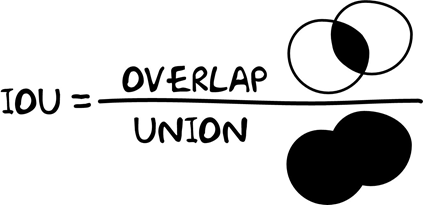

In [10]:
def calc_val_data(preds, masks, num_classes):
    # batch_size x num_classes x H x W
    softmax     = torch.nn.Softmax(dim=1)
    probability = softmax(preds)
    preds = torch.argmax(preds, dim=1)
    batch_size=preds.shape[0]
    
    intersection = [] 
    union = [] 
    target = [] 

    for i in range(num_classes): # Go over all classes
        net_out_ = (preds == i)
        target_ = (masks == i)
        intersection.append(torch.sum(net_out_* target_, dim = (1, 2)))
        union.append(torch.sum(torch.maximum(net_out_, target_), dim = (1, 2)))
        target.append(torch.sum(target_, dim = (1, 2)))
    intersection, union, target = torch.permute(torch.stack(intersection), (1,0)),  torch.permute(torch.stack(union), (1,0)),  torch.permute(torch.stack(target), (1,0))
    assert isinstance(intersection, torch.Tensor), 'Output should be a tensor'
    assert isinstance(union, torch.Tensor), 'Output should be a tensor'
    assert isinstance(target, torch.Tensor), 'Output should be a tensor'

    assert intersection.shape == union.shape == target.shape, 'Wrong output shape'
    
    assert union.shape[0] == masks.shape[0] and union.shape[1] == num_classes, 'Wrong output shape'

    return intersection, union, target

$mean IoU = \frac{1}{|classes|} \sum_{i=1}^{|classes|} IoU(class)$

In [12]:
def iou(intersection, union, eps=1e-6):
    #Если мы найдем класс, которого не, то метрика даст 0, а если класса нет и не нашли, то Nan 
    return (intersection)/(union)

def recall(intersection, target, eps=1e-6):
    return (intersection)/(target)

def accuracy(intersection, union, total, eps=1e-6):
    total = torch.unsqueeze(total, dim = -1)
    TP_TN = torch.sub(total,  union - intersection)
    return (TP_TN)/(total)

def calc_val_loss(intersection, union, target, eps = 1e-7):
    # average over classes
    mean_iou = ... # TODO: calc mean class iou
    mean_class_rec = ... # TODO: calc mean class recall
    mean_acc = ... # TODO: calc mean accuracy
    total = torch.sum(target, dim = 1)
    mean_iou = iou(intersection, union)
    mean_class_rec = recall(intersection, target)
    mean_acc = accuracy(intersection, union, total)
    #Nanmean позволяет удобно разобраться с случаями, когда класса протсо нет на картинке, т.к. когда мы хотим его не учитывать, то выдаем Nan
    mean_iou, mean_class_rec, mean_acc = torch.nanmean(mean_iou), torch.nanmean(mean_class_rec), torch.nanmean(mean_acc)
    return mean_iou, mean_class_rec, mean_acc

Обновленные метрики от Матвея

In [10]:
def iou(net_output, target, class_label=torch.tensor(1).type(torch.int), eps=1e-6):
    net_out_ = (net_output == class_label)
    target_ = (target == class_label)
    return (torch.sum(net_out_ * target_))/(torch.sum(torch.maximum(net_out_, target_)) + eps)

def recall(net_output, target, class_label=torch.tensor(1).type(torch.int), eps=1e-6):
    net_out_ = (net_output == class_label)
    target_ = (target == class_label)
    return (torch.sum(net_out_ * target_))/(torch.sum(target_) + eps)

def accuracy(net_output, target, class_label=torch.tensor(1).type(torch.int), eps=1e-6):
    net_out_ = (net_output == class_label)
    target_ = (target == class_label)
    return (torch.sum(net_out_ == target_))/(torch.sum(torch.ones_like(target_)) + eps)

def calc_val_data(outputs, masks, num_classes):
    softmax     = torch.nn.Softmax(dim=1)
    probability = softmax(outputs)
    prediction  = torch.argmax(probability, dim=1)
    mean_iou, mean_recall, mean_acc = [], [], []

    for i in range(outputs.shape[1]):
        mean_iou.append(iou(prediction, masks, i).item())
        mean_recall.append(recall(prediction, masks, i).item())
        mean_acc.append(accuracy(prediction, masks, i).item())
    return np.mean(mean_iou), np.mean(mean_recall), np.mean(mean_acc)

### Model

В качестве базовой модели будем использовать UNet. Архитектура представлена ниже. Вам не нужно точно воспроизвести архитектуру. Важно реализовать передачу intermediate features, полученные от encoder к decoder.

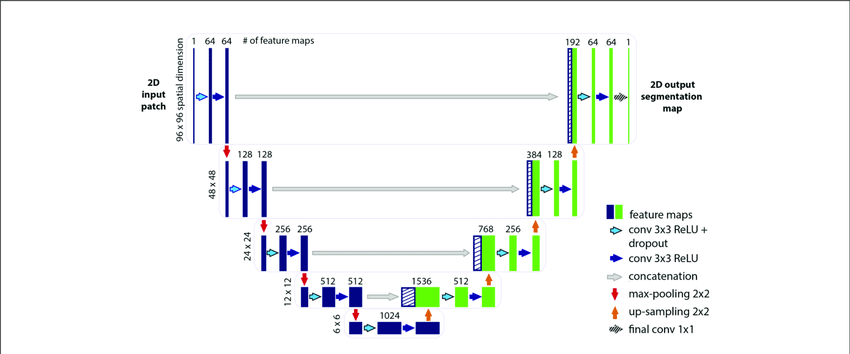

In [9]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models

class DownBlock(nn.Module):
    def __init__(self, in_channel, out_channel, down=True):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, padding='same', padding_mode = 'reflect'),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, 3, padding='same', padding_mode = 'reflect'),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )
        self.pooling = torch.nn.MaxPool2d(2)
        # TODO

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pooling(x)
        return x

In [10]:
class UpBlock(nn.Module):
    def __init__(self, in_channel, prev_channel, out_channel, up=True):
        super().__init__()
        self.upsampling = nn.ConvTranspose2d(prev_channel, prev_channel, kernel_size=2, padding=0, stride=2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel+prev_channel, out_channel, 3, padding='same', padding_mode = 'reflect'),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, 3, padding='same', padding_mode = 'reflect'),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )
        
        # TODO

    def forward(self, x, res=None):
        x = self.upsampling(x)
        x = self.conv1(torch.cat((res, x), dim=1))
        x = self.conv2(x)
        return x

Теперь совместим encoder и decoder в одну архитектуру

In [11]:
class UNet(nn.Module):
    """
    Используя UpBlock и DownBlock, реализуйте полноценную архитектуру.
    Учтите, что разрешение изображение может не делиться на 2**num_down_blocks, поэтому
    вам нужно интерполировать его до нужного разрешения

    Для уменьшения/увеличения размерности можете использовать любой удобный вам метод
    """

    def __init__(self,
                 num_classes,
                 min_channels=32,
                 max_channels=512,
                 num_down_blocks=4):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.num_down_blocks = num_down_blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, min_channels, 3, padding='same', padding_mode = 'reflect'),
            nn.BatchNorm2d(min_channels),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(min_channels, min_channels, 3, padding='same', padding_mode = 'reflect'),
            nn.BatchNorm2d(min_channels),
            nn.ReLU()
        )

        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        prev_chanel = min_channels
        self.chanel_size = []
        for i in range(self.num_down_blocks):
            self.chanel_size.append(prev_chanel)
            out_chanel = prev_chanel * 2
            self.down_blocks.append(DownBlock(prev_chanel, out_chanel))
            prev_chanel = out_chanel
        
        
        for i in range(self.num_down_blocks):
            self.up_blocks.append(UpBlock(self.chanel_size[self.num_down_blocks - i - 1], prev_chanel, self.chanel_size[self.num_down_blocks - i - 1]))
            prev_chanel = self.chanel_size[self.num_down_blocks - i - 1]
        self.final_conv = nn.Conv2d(self.chanel_size[0], num_classes, 1)
        # TODO

    def forward(self, inputs):
        # TODO
        width = inputs.shape[-1]
        height = inputs.shape[-2]
        width_ = 2 ** self.num_down_blocks - ((width - 1) % (2 ** self.num_down_blocks) + 1)
        height_ = 2 ** self.num_down_blocks- ((height- 1) % (2 ** self.num_down_blocks)  + 1)
        padding = torch.nn.ReflectionPad2d((0, width_, 0, height_))
        x = padding(inputs)
        x = self.conv1(x)
        x = self.conv2(x)
        x_skip = [x]
        for i in range(self.num_down_blocks):
            x = self.down_blocks[i](x)
            x_skip.append(x)
        x_skip = x_skip[:-1]
        for i in range(self.num_down_blocks):
            x = self.up_blocks[i](x, x_skip[ self.num_down_blocks - i - 1])
        x = self.final_conv(x)
        logits = x[:, :, :height, :width]
        assert logits.shape == (inputs.shape[0], self.num_classes, inputs.shape[2], inputs.shape[3]), 'Wrong shape of the logits'
        return logits

In [12]:
device='cuda:0'

m = UNet(NUM_CLASSES).to(device)

### Training

In [13]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [14]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(m.parameters(), lr=1e-4)
tb = SummaryWriter()

global_step = 0
scaler = torch.cuda.amp.GradScaler()

for epoch in range(30):
    m.train()
    for batch in tqdm.tqdm(train_dataloader, position=0):
        x, y = batch[0].to(device), batch[1].to(device)
        with torch.autocast(device_type="cuda"):
            pred = m(x)
            loss = criterion(pred, y)

        tb.add_scalar("train_loss", loss.item(), global_step)
        optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        global_step += 1

        if global_step % 100 == 0:
            print(loss.item())

    intersection, union, target = torch.Tensor().to(device), torch.Tensor().to(device), torch.Tensor().to(device)
    with torch.no_grad():
        m.eval()
        for batch in tqdm.tqdm(val_dataloader):
            x, y = batch[0].to(device), batch[1].to(device)
            with torch.autocast(device_type="cuda"):
                pred = m(x)

                loss = criterion(pred, y)

            tmp_intersection, tmp_union, tmp_target = calc_val_data(pred, y, 8)
            # batch_size x num_classes x H x W

            intersection = torch.cat((intersection, tmp_intersection))
            union = torch.cat((union, tmp_union))
            target = torch.cat((target, tmp_target))

    mean_iou, mean_class_rec, mean_acc = calc_val_loss(intersection, union, target, eps = 1e-7)

    print(f"Epoch {epoch}, val_mIoU={mean_iou}, val_mRecall={mean_class_rec}, val_mAcc={mean_acc}")
    tb.add_scalar("val_mean_iou", mean_iou, epoch)
    tb.add_scalar("val_mean_class_rec", mean_class_rec, epoch)
    tb.add_scalar("val_mean_acc", mean_acc, epoch)

100%|██████████| 35/35 [00:05<00:00,  6.31it/s]


Epoch 0, val_mIoU=0.15720760822296143, val_mRecall=0.3275415897369385, val_mAcc=0.8757470846176147


 28%|██▊       | 22/78 [00:16<00:25,  2.17it/s]

1.4659825563430786


100%|██████████| 35/35 [00:03<00:00, 10.29it/s]


Epoch 1, val_mIoU=0.16760651767253876, val_mRecall=0.3555346727371216, val_mAcc=0.8809282779693604


 56%|█████▋    | 44/78 [00:31<00:18,  1.79it/s]

1.6148645877838135


100%|██████████| 35/35 [00:03<00:00, 10.62it/s]


Epoch 2, val_mIoU=0.18484841287136078, val_mRecall=0.3697991669178009, val_mAcc=0.8812658190727234


 85%|████████▍ | 66/78 [00:47<00:07,  1.67it/s]

1.5036686658859253


100%|██████████| 35/35 [00:03<00:00,  8.96it/s]


Epoch 3, val_mIoU=0.1850501149892807, val_mRecall=0.32748857140541077, val_mAcc=0.876448929309845


100%|██████████| 35/35 [00:03<00:00, 10.38it/s]


Epoch 4, val_mIoU=0.19326598942279816, val_mRecall=0.3340516686439514, val_mAcc=0.8762665390968323


 13%|█▎        | 10/78 [00:06<00:42,  1.61it/s]

0.9908896088600159


100%|██████████| 35/35 [00:04<00:00,  7.15it/s]


Epoch 5, val_mIoU=0.20159092545509338, val_mRecall=0.3483726680278778, val_mAcc=0.8784618377685547


 41%|████      | 32/78 [00:19<00:35,  1.30it/s]

1.1070691347122192


100%|██████████| 35/35 [00:04<00:00,  8.20it/s]


Epoch 6, val_mIoU=0.23603588342666626, val_mRecall=0.4038308560848236, val_mAcc=0.8888140916824341


 69%|██████▉   | 54/78 [00:39<00:14,  1.68it/s]

1.0470097064971924


100%|██████████| 35/35 [00:03<00:00, 11.32it/s]


Epoch 7, val_mIoU=0.2118697166442871, val_mRecall=0.3508721888065338, val_mAcc=0.8787523508071899


 97%|█████████▋| 76/78 [00:44<00:01,  1.73it/s]

0.9892699122428894


100%|██████████| 35/35 [00:03<00:00, 10.31it/s]


Epoch 8, val_mIoU=0.20692911744117737, val_mRecall=0.33979809284210205, val_mAcc=0.8779280781745911


100%|██████████| 35/35 [00:04<00:00,  7.96it/s]


Epoch 9, val_mIoU=0.1904204785823822, val_mRecall=0.30891603231430054, val_mAcc=0.8741455078125


 26%|██▌       | 20/78 [00:13<00:59,  1.02s/it]

0.8192160129547119


100%|██████████| 35/35 [00:04<00:00,  8.71it/s]


Epoch 10, val_mIoU=0.24050293862819672, val_mRecall=0.3769673705101013, val_mAcc=0.8891206979751587


 54%|█████▍    | 42/78 [00:26<00:19,  1.83it/s]

1.0234172344207764


100%|██████████| 35/35 [00:03<00:00, 11.26it/s]


Epoch 11, val_mIoU=0.23957112431526184, val_mRecall=0.3661368489265442, val_mAcc=0.8885984420776367


 82%|████████▏ | 64/78 [00:35<00:07,  1.91it/s]

0.932796835899353


100%|██████████| 35/35 [00:03<00:00, 10.59it/s]


Epoch 12, val_mIoU=0.271329790353775, val_mRecall=0.424788236618042, val_mAcc=0.8996990919113159


100%|██████████| 35/35 [00:03<00:00, 11.22it/s]


Epoch 13, val_mIoU=0.15884768962860107, val_mRecall=0.2638380229473114, val_mAcc=0.8673054575920105


 10%|█         | 8/78 [00:04<00:35,  1.99it/s]

0.6123077273368835


100%|██████████| 35/35 [00:03<00:00, 10.45it/s]


Epoch 14, val_mIoU=0.19419221580028534, val_mRecall=0.30056825280189514, val_mAcc=0.8764604926109314


 38%|███▊      | 30/78 [00:17<00:25,  1.85it/s]

0.7850950956344604


100%|██████████| 35/35 [00:04<00:00,  7.19it/s]


Epoch 15, val_mIoU=0.19877614080905914, val_mRecall=0.3161182999610901, val_mAcc=0.8768741488456726


 67%|██████▋   | 52/78 [00:39<00:13,  1.86it/s]

1.2018160820007324


100%|██████████| 35/35 [00:02<00:00, 12.27it/s]


Epoch 16, val_mIoU=0.2036096155643463, val_mRecall=0.3169078230857849, val_mAcc=0.8814442753791809


 95%|█████████▍| 74/78 [00:56<00:03,  1.01it/s]

0.7527770400047302


100%|██████████| 35/35 [00:05<00:00,  6.36it/s]


Epoch 17, val_mIoU=0.22268922626972198, val_mRecall=0.3442675769329071, val_mAcc=0.8871092796325684


100%|██████████| 35/35 [00:03<00:00,  9.01it/s]


Epoch 18, val_mIoU=0.22881019115447998, val_mRecall=0.35262033343315125, val_mAcc=0.887256920337677


 23%|██▎       | 18/78 [00:16<00:58,  1.02it/s]

0.5172496438026428


100%|██████████| 35/35 [00:05<00:00,  6.11it/s]


Epoch 19, val_mIoU=0.21498773992061615, val_mRecall=0.32965829968452454, val_mAcc=0.8842445611953735


 51%|█████▏    | 40/78 [00:41<00:23,  1.59it/s]

1.071014165878296


100%|██████████| 35/35 [00:04<00:00,  7.53it/s]


Epoch 20, val_mIoU=0.25064703822135925, val_mRecall=0.3806014060974121, val_mAcc=0.8935346603393555


 79%|███████▉  | 62/78 [00:50<00:11,  1.41it/s]

1.0707621574401855


100%|██████████| 35/35 [00:03<00:00,  9.51it/s]


Epoch 21, val_mIoU=0.25088217854499817, val_mRecall=0.37638744711875916, val_mAcc=0.8931876420974731


100%|██████████| 35/35 [00:03<00:00, 10.86it/s]


Epoch 22, val_mIoU=0.2141241729259491, val_mRecall=0.3316980302333832, val_mAcc=0.8847011923789978


  8%|▊         | 6/78 [00:03<00:36,  1.98it/s]

0.5610307455062866


100%|██████████| 35/35 [00:06<00:00,  5.69it/s]


Epoch 23, val_mIoU=0.24529744684696198, val_mRecall=0.38054755330085754, val_mAcc=0.892879068851471


 36%|███▌      | 28/78 [00:21<00:48,  1.03it/s]

0.641734778881073


100%|██████████| 35/35 [00:09<00:00,  3.66it/s]


Epoch 24, val_mIoU=0.2597857415676117, val_mRecall=0.39100828766822815, val_mAcc=0.8912544250488281


 64%|██████▍   | 50/78 [00:42<00:17,  1.58it/s]

0.5332555174827576


100%|██████████| 35/35 [00:08<00:00,  4.16it/s]


Epoch 25, val_mIoU=0.25819745659828186, val_mRecall=0.39580413699150085, val_mAcc=0.8950350880622864


 92%|█████████▏| 72/78 [00:54<00:03,  1.59it/s]

0.7904068231582642


100%|██████████| 35/35 [00:05<00:00,  6.20it/s]


Epoch 26, val_mIoU=0.2175949215888977, val_mRecall=0.328290730714798, val_mAcc=0.8848329782485962


100%|██████████| 35/35 [00:04<00:00,  7.48it/s]


Epoch 27, val_mIoU=0.24654263257980347, val_mRecall=0.38277971744537354, val_mAcc=0.8926282525062561


 21%|██        | 16/78 [00:13<00:40,  1.53it/s]

0.6103052496910095


100%|██████████| 35/35 [00:04<00:00,  8.22it/s]


Epoch 28, val_mIoU=0.19941346347332, val_mRecall=0.30776116251945496, val_mAcc=0.8744109272956848


 49%|████▊     | 38/78 [00:24<00:20,  1.93it/s]

0.41669538617134094


100%|██████████| 35/35 [00:04<00:00,  8.41it/s]


Epoch 29, val_mIoU=0.25714826583862305, val_mRecall=0.38944029808044434, val_mAcc=0.8953650593757629


In [15]:
torch.save(m, './models/baseline_unet_model.pth')

In [16]:
%load_ext tensorboard
%tensorboard --logdir runs/

### Визуалзация базового решения

In [25]:
import torchvision 
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [26]:
num_down_blocks = 5
from torchvision.utils import draw_segmentation_masks
import torchvision
def show_segmentation(orig_image, model_):
    #img_size = 256
    #transform = A.RandomCrop(width=img_size, height=img_size)
    #augmented = transform(image=image, mask=mask)
    #image = augmented['image']
    #mask = augmented['mask']

    image = torchvision.transforms.functional.to_tensor(orig_image.copy())
    image = torch.unsqueeze(image, dim = 0)
    


    image_ = image.to(device)

    width = image_.shape[-1]
    height = image_.shape[-2]
    width_ = 2 ** num_down_blocks - ((width - 1) % (2 ** num_down_blocks) + 1)
    height_ = 2 ** num_down_blocks- ((height- 1) % (2 ** num_down_blocks)  + 1)
    padding = torch.nn.ReflectionPad2d((0, width_, 0, height_))
    image_ = padding(image_)

    preds = model_(image_)
    preds = preds[:, :, :height, :width]
    all_classes_masks = torch.argmax(preds, dim=1) == torch.arange(NUM_CLASSES, device = device)[:, None, None, None]
    all_classes_masks = all_classes_masks.swapaxes(0, 1)

    print(preds.shape)
    print(all_classes_masks.shape)

    image = torch.tensor(orig_image, dtype=torch.uint8)
    image = torch.unsqueeze(image, dim = 0)
    image = image.permute(0, 3, 1, 2)
    print(image.shape)
    """
    Классы:
    0: Background, 1: Building, 2: Road, 3: Water, 4: Tree, 5: Vehicle, 6: Pool, 7: Grass
    """
    dogs_with_masks = [
        draw_segmentation_masks(img, masks=mask_, alpha=.4, colors = ['black', 'blue', 'green', 'yellow', 'pink', 'orange', 'red', 'purple'])
        for img, mask_ in zip(image, all_classes_masks)
    ]
    show(dogs_with_masks)
    show(image[0])

Если модель не загружена

In [19]:
m = torch.load('./models/baseline_unet_model.pth')

torch.Size([1, 8, 750, 1000])
torch.Size([1, 8, 750, 1000])
torch.Size([1, 3, 750, 1000])


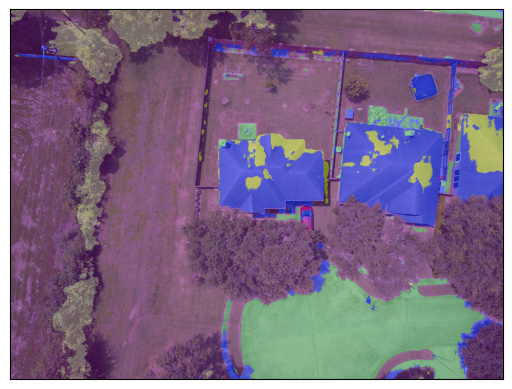

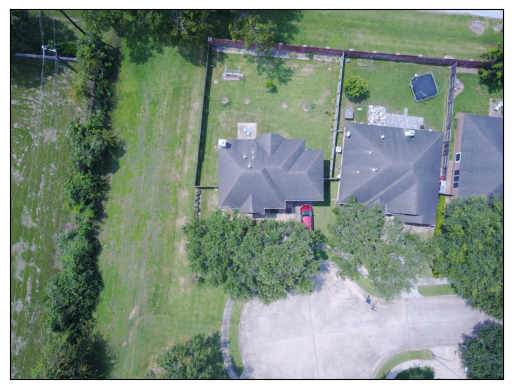

In [21]:
data_path = "tiny-floodnet-challenge"
phase = "test"
index = 9925
orig_image = np.asarray(Image.open(f'{data_path}/{phase}/image/{index}.jpg'))
show_segmentation(orig_image, m)

torch.Size([1, 8, 750, 1000])
torch.Size([1, 8, 750, 1000])
torch.Size([1, 3, 750, 1000])


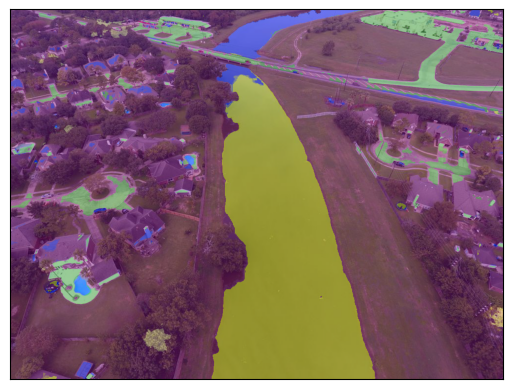

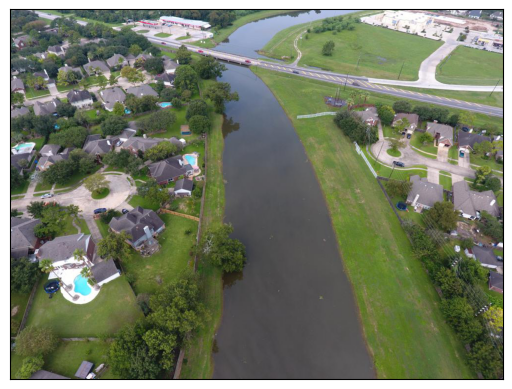

In [22]:
index = 9351
orig_image = np.asarray(Image.open(f'{data_path}/{phase}/image/{index}.jpg'))
show_segmentation(orig_image, m)

torch.Size([1, 8, 750, 1000])
torch.Size([1, 8, 750, 1000])
torch.Size([1, 3, 750, 1000])


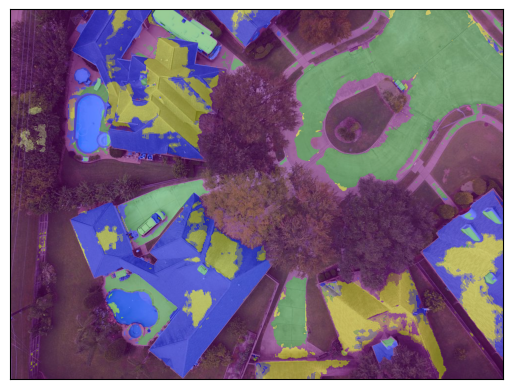

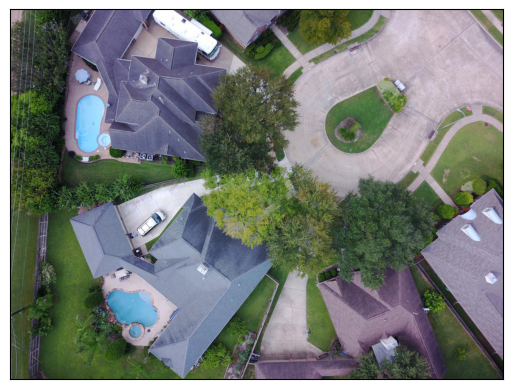

In [23]:
index = 9093
orig_image = np.asarray(Image.open(f'{data_path}/{phase}/image/{index}.jpg'))
show_segmentation(orig_image, m)

## Часть 2: Ваше решение (2/3 от максимального числа баллов)

В данной задаче предстоит выбить скор 45 mAcc на валидации.

Для решения можно использовать любые фреймворки, методы, модели.

Рекомендация к решению:
- Удобно будет воспользоваться предобученными моделями из [mmsegmentation](https://mmsegmentation.readthedocs.io/)
- Для реализации аугментаций вы можете воспользоваться библиотекой [albumentations](https://albumentations.ai/docs/)


В качестве решения вам нужно предоставить:

- checkpoint вашей модели.
- скрипт с загрузкой модели и её инференса вашей модели на валидационной выборке.
- отчет о решении в TeX / Markdown.

Отчет должен включать себя:

- описание финального решения. Какие техники/методы/архитектуры вы использовали. Также в эту часть должны быть включены кривые обучения для финального решения (Cross entropy loss, mean IoU, mean Acc). Для кривых обучения можете использовать tensorboard logs.

- описание промежуточных экспериментов, которые показывают процесс ваших размышлений при выборе тех или иных решений.

### Ваше решение

Basline-Unet уже умеет отделяет разные объекты на изображении, но она все еще путает здания с водой, т. е. у нfс есть проблемы с разделением отдельных классов. Поэтому в качетсве энкодора для нашей модели можно взять предобученную классификационную CNN, остальные части можно оставить неизменными. В качестве классификационной сети взята ResNet50

Для удобства построения можно использовать уже готовую модель UNet из [segmentaionmodels](https://github.com/qubvel/segmentation_models.pytorch?ysclid=loy6sg561d396937278)

In [13]:
device='cuda:0'

ResNet предобучена на датасете ImageNet

In [37]:
import segmentation_models_pytorch as smp
BACKBONE = 'resnet50'
model = smp.Unet(BACKBONE, classes=NUM_CLASSES, activation='sigmoid', encoder_weights='imagenet').to(device)

Используем тензорные ядра и половинную точность ,где возможно для ускорения

In [38]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

Зафиксируем предобученные параметры из ResNet, мы обучаем только декодер

In [39]:
for param in list(model.encoder.parameters())[:]:
    param.requires_grad = False

### Train

In [40]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay = 0.05)
tb = SummaryWriter()

global_step = 0
scaler = torch.cuda.amp.GradScaler()
num_down_blocks = 5
max_miou = 0
for epoch in range(500):
    model.train()
    for batch in tqdm.tqdm(train_dataloader, position=0):
        x, y = batch[0].to(device), batch[1].to(device)

        width = x.shape[-1]
        height = x.shape[-2]
        width_ = 2 ** num_down_blocks - ((width - 1) % (2 ** num_down_blocks) + 1)
        height_ = 2 ** num_down_blocks- ((height- 1) % (2 ** num_down_blocks)  + 1)
        padding = torch.nn.ReflectionPad2d((0, width_, 0, height_))
        x = padding(x)

        with torch.autocast(device_type="cuda"):
            pred = model(x)
            pred = pred[:, :, :height, :width]
            loss = criterion(pred, y)

        tb.add_scalar("train_loss", loss.item(), global_step)
        optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        global_step += 1

        if global_step % 100 == 0:
            print(loss.item())

    intersection, union, target = torch.Tensor().to(device), torch.Tensor().to(device), torch.Tensor().to(device)
    with torch.no_grad():
        model.eval()
        for batch in tqdm.tqdm(val_dataloader):
            x, y = batch[0].to(device), batch[1].to(device)

            
            width = x.shape[-1]
            height = x.shape[-2]
            width_ = 2 ** num_down_blocks - ((width - 1) % (2 ** num_down_blocks) + 1)
            height_ = 2 ** num_down_blocks- ((height- 1) % (2 ** num_down_blocks)  + 1)
            padding = torch.nn.ReflectionPad2d((0, width_, 0, height_))
            x = padding(x)

            with torch.autocast(device_type="cuda"):
                pred = model(x)
                pred = pred[:, :, :height, :width]
                loss = criterion(pred, y)

            tmp_intersection, tmp_union, tmp_target = calc_val_data(pred, y, 8)
            # batch_size x num_classes x H x W

            intersection = torch.cat((intersection, tmp_intersection))
            union = torch.cat((union, tmp_union))
            target = torch.cat((target, tmp_target))

    mean_iou, mean_class_rec, mean_acc = calc_val_loss(intersection, union, target, eps = 1e-7)
    if max_miou < mean_iou:
        max_miou = mean_iou
        torch.save(model, './models/resunet_model.pth')
        print("Better model founded!")
    print(f"Epoch {epoch}, val_mIoU={mean_iou}, val_mRecall={mean_class_rec}, val_mAcc={mean_acc}")
    tb.add_scalar("val_mean_iou", mean_iou, epoch)
    tb.add_scalar("val_mean_class_rec", mean_class_rec, epoch)
    tb.add_scalar("val_mean_acc", mean_acc, epoch)

100%|██████████| 35/35 [00:01<00:00, 34.33it/s]


Better model founded!
Epoch 0, val_mIoU=0.11845245212316513, val_mRecall=0.28634530305862427, val_mAcc=0.8463504910469055


100%|██████████| 35/35 [00:01<00:00, 34.82it/s]


Better model founded!
Epoch 1, val_mIoU=0.16105589270591736, val_mRecall=0.3669484257698059, val_mAcc=0.8821102976799011


 59%|█████▉    | 23/39 [00:03<00:02,  7.76it/s]

1.7929962873458862


100%|██████████| 35/35 [00:00<00:00, 39.00it/s]


Epoch 2, val_mIoU=0.15601846575737, val_mRecall=0.3666779696941376, val_mAcc=0.8755981922149658


100%|██████████| 35/35 [00:00<00:00, 38.99it/s]


Better model founded!
Epoch 3, val_mIoU=0.1768542230129242, val_mRecall=0.4002682566642761, val_mAcc=0.8882150053977966


100%|██████████| 35/35 [00:00<00:00, 37.17it/s]


Epoch 4, val_mIoU=0.17159439623355865, val_mRecall=0.3997431695461273, val_mAcc=0.886109471321106


 15%|█▌        | 6/39 [00:01<00:04,  6.91it/s]

1.6900275945663452


100%|██████████| 35/35 [00:00<00:00, 40.40it/s]


Epoch 5, val_mIoU=0.17471018433570862, val_mRecall=0.4078710973262787, val_mAcc=0.8875613808631897


100%|██████████| 35/35 [00:00<00:00, 36.44it/s]


Better model founded!
Epoch 6, val_mIoU=0.20819759368896484, val_mRecall=0.4316956400871277, val_mAcc=0.8984158039093018


 72%|███████▏  | 28/39 [00:03<00:01,  7.56it/s]

1.5808578729629517


100%|██████████| 35/35 [00:00<00:00, 39.46it/s]


Better model founded!
Epoch 7, val_mIoU=0.2543766498565674, val_mRecall=0.490208238363266, val_mAcc=0.9136665463447571


100%|██████████| 35/35 [00:00<00:00, 36.42it/s]


Better model founded!
Epoch 8, val_mIoU=0.26337897777557373, val_mRecall=0.4764551818370819, val_mAcc=0.9155486822128296


100%|██████████| 35/35 [00:00<00:00, 37.13it/s]


Better model founded!
Epoch 9, val_mIoU=0.28774532675743103, val_mRecall=0.5176263451576233, val_mAcc=0.9195467233657837


 28%|██▊       | 11/39 [00:01<00:03,  7.52it/s]

1.501024603843689


100%|██████████| 35/35 [00:00<00:00, 39.04it/s]


Better model founded!
Epoch 10, val_mIoU=0.3059970438480377, val_mRecall=0.523914098739624, val_mAcc=0.924724280834198


100%|██████████| 35/35 [00:00<00:00, 36.00it/s]


Better model founded!
Epoch 11, val_mIoU=0.359138160943985, val_mRecall=0.5907934904098511, val_mAcc=0.9359939694404602


 85%|████████▍ | 33/39 [00:04<00:00,  7.89it/s]

1.457206130027771


100%|██████████| 35/35 [00:00<00:00, 38.93it/s]


Epoch 12, val_mIoU=0.35692477226257324, val_mRecall=0.5700654983520508, val_mAcc=0.9311623573303223


100%|██████████| 35/35 [00:00<00:00, 37.39it/s]


Better model founded!
Epoch 13, val_mIoU=0.37618380784988403, val_mRecall=0.6028622388839722, val_mAcc=0.9355783462524414


100%|██████████| 35/35 [00:00<00:00, 38.89it/s]


Epoch 14, val_mIoU=0.3601415157318115, val_mRecall=0.5573911666870117, val_mAcc=0.9291876554489136


 41%|████      | 16/39 [00:02<00:02,  7.67it/s]

1.5280393362045288


100%|██████████| 35/35 [00:00<00:00, 37.30it/s]


Epoch 15, val_mIoU=0.34636321663856506, val_mRecall=0.5266813635826111, val_mAcc=0.9253555536270142


100%|██████████| 35/35 [00:00<00:00, 41.57it/s]


Epoch 16, val_mIoU=0.34446582198143005, val_mRecall=0.482357382774353, val_mAcc=0.9210761785507202


 97%|█████████▋| 38/39 [00:05<00:00,  7.87it/s]

1.424477219581604


100%|██████████| 35/35 [00:00<00:00, 41.16it/s]


Epoch 17, val_mIoU=0.3593600392341614, val_mRecall=0.5198260545730591, val_mAcc=0.9271863698959351


100%|██████████| 35/35 [00:00<00:00, 35.62it/s]


Epoch 18, val_mIoU=0.33259811997413635, val_mRecall=0.4963970184326172, val_mAcc=0.9216939806938171


100%|██████████| 35/35 [00:00<00:00, 36.84it/s]


Epoch 19, val_mIoU=0.3500128984451294, val_mRecall=0.4998706877231598, val_mAcc=0.9235833287239075


 54%|█████▍    | 21/39 [00:03<00:02,  7.63it/s]

1.4042716026306152


100%|██████████| 35/35 [00:00<00:00, 39.19it/s]


Epoch 20, val_mIoU=0.3155955672264099, val_mRecall=0.43982237577438354, val_mAcc=0.9148274064064026


100%|██████████| 35/35 [00:00<00:00, 40.40it/s]


Epoch 21, val_mIoU=0.33997267484664917, val_mRecall=0.5008846521377563, val_mAcc=0.9231719970703125


100%|██████████| 35/35 [00:00<00:00, 35.30it/s]


Epoch 22, val_mIoU=0.3531287908554077, val_mRecall=0.4845191538333893, val_mAcc=0.9219465851783752


 10%|█         | 4/39 [00:00<00:06,  5.73it/s]

1.455430507659912


100%|██████████| 35/35 [00:00<00:00, 40.37it/s]


Epoch 23, val_mIoU=0.3565506935119629, val_mRecall=0.5108596086502075, val_mAcc=0.9243795275688171


100%|██████████| 35/35 [00:00<00:00, 35.86it/s]


Epoch 24, val_mIoU=0.348468154668808, val_mRecall=0.5003077983856201, val_mAcc=0.9228103756904602


 67%|██████▋   | 26/39 [00:03<00:01,  7.75it/s]

1.421126127243042


100%|██████████| 35/35 [00:00<00:00, 36.25it/s]


Epoch 25, val_mIoU=0.35031697154045105, val_mRecall=0.5099093317985535, val_mAcc=0.9241806268692017


100%|██████████| 35/35 [00:00<00:00, 37.63it/s]


Epoch 26, val_mIoU=0.3647474944591522, val_mRecall=0.5028846859931946, val_mAcc=0.9252021908760071


100%|██████████| 35/35 [00:00<00:00, 35.06it/s]


Epoch 27, val_mIoU=0.3537549376487732, val_mRecall=0.5079990029335022, val_mAcc=0.9238083958625793


 23%|██▎       | 9/39 [00:01<00:03,  7.53it/s]

1.4152847528457642


100%|██████████| 35/35 [00:00<00:00, 41.27it/s]


Epoch 28, val_mIoU=0.35605743527412415, val_mRecall=0.4804342985153198, val_mAcc=0.9219447374343872


100%|██████████| 35/35 [00:00<00:00, 40.90it/s]


Epoch 29, val_mIoU=0.3511940538883209, val_mRecall=0.49996986985206604, val_mAcc=0.9217638373374939


 79%|███████▉  | 31/39 [00:04<00:01,  7.92it/s]

1.4206976890563965


100%|██████████| 35/35 [00:00<00:00, 38.88it/s]


Epoch 30, val_mIoU=0.3452671468257904, val_mRecall=0.5120152235031128, val_mAcc=0.922282874584198


100%|██████████| 35/35 [00:00<00:00, 37.06it/s]


Epoch 31, val_mIoU=0.35405293107032776, val_mRecall=0.48709970712661743, val_mAcc=0.9219679832458496


100%|██████████| 35/35 [00:00<00:00, 37.91it/s]


Epoch 32, val_mIoU=0.3648807406425476, val_mRecall=0.4910695552825928, val_mAcc=0.9243966341018677


 36%|███▌      | 14/39 [00:02<00:03,  7.83it/s]

1.375234603881836


100%|██████████| 35/35 [00:00<00:00, 39.77it/s]


Epoch 33, val_mIoU=0.3507480323314667, val_mRecall=0.4699476957321167, val_mAcc=0.9212936162948608


100%|██████████| 35/35 [00:00<00:00, 39.32it/s]


Epoch 34, val_mIoU=0.3661745488643646, val_mRecall=0.47895246744155884, val_mAcc=0.9223917126655579


 92%|█████████▏| 36/39 [00:04<00:00,  7.64it/s]

1.432923674583435


100%|██████████| 35/35 [00:00<00:00, 35.26it/s]


Epoch 35, val_mIoU=0.35967114567756653, val_mRecall=0.4994405210018158, val_mAcc=0.9232151508331299


100%|██████████| 35/35 [00:00<00:00, 38.50it/s]


Epoch 36, val_mIoU=0.373221755027771, val_mRecall=0.505334198474884, val_mAcc=0.9269018769264221


100%|██████████| 35/35 [00:00<00:00, 39.97it/s]


Epoch 37, val_mIoU=0.3600084185600281, val_mRecall=0.5092447400093079, val_mAcc=0.9263966083526611


 49%|████▊     | 19/39 [00:02<00:02,  7.89it/s]

1.3494927883148193


100%|██████████| 35/35 [00:01<00:00, 34.37it/s]


Epoch 38, val_mIoU=0.37291115522384644, val_mRecall=0.4925168752670288, val_mAcc=0.9223368167877197


100%|██████████| 35/35 [00:01<00:00, 34.92it/s]


Epoch 39, val_mIoU=0.36385753750801086, val_mRecall=0.4958840012550354, val_mAcc=0.9243658781051636


100%|██████████| 35/35 [00:00<00:00, 37.41it/s]


Epoch 40, val_mIoU=0.3449332118034363, val_mRecall=0.49888989329338074, val_mAcc=0.9223581552505493


  5%|▌         | 2/39 [00:00<00:08,  4.27it/s]

1.378154993057251


100%|██████████| 35/35 [00:00<00:00, 41.46it/s]


Epoch 41, val_mIoU=0.36007019877433777, val_mRecall=0.48763540387153625, val_mAcc=0.9220834970474243


100%|██████████| 35/35 [00:00<00:00, 36.52it/s]


Epoch 42, val_mIoU=0.3701740801334381, val_mRecall=0.5019963979721069, val_mAcc=0.9248955845832825


 62%|██████▏   | 24/39 [00:03<00:01,  7.75it/s]

1.3932132720947266


100%|██████████| 35/35 [00:00<00:00, 38.40it/s]


Epoch 43, val_mIoU=0.3639812469482422, val_mRecall=0.49941712617874146, val_mAcc=0.9254980683326721


100%|██████████| 35/35 [00:01<00:00, 34.03it/s]


Epoch 44, val_mIoU=0.36322322487831116, val_mRecall=0.49422433972358704, val_mAcc=0.924823522567749


100%|██████████| 35/35 [00:00<00:00, 36.88it/s]


Epoch 45, val_mIoU=0.3652389943599701, val_mRecall=0.4929710030555725, val_mAcc=0.9235658645629883


 18%|█▊        | 7/39 [00:01<00:04,  7.17it/s]

1.3637943267822266


100%|██████████| 35/35 [00:00<00:00, 37.60it/s]


Epoch 46, val_mIoU=0.3645080029964447, val_mRecall=0.49669310450553894, val_mAcc=0.9246354103088379


100%|██████████| 35/35 [00:01<00:00, 34.04it/s]


Epoch 47, val_mIoU=0.3658924102783203, val_mRecall=0.4944995045661926, val_mAcc=0.9238469004631042


 74%|███████▍  | 29/39 [00:03<00:01,  7.71it/s]

1.4038755893707275


100%|██████████| 35/35 [00:00<00:00, 39.84it/s]


Epoch 48, val_mIoU=0.3627670109272003, val_mRecall=0.5023526549339294, val_mAcc=0.9257223010063171


100%|██████████| 35/35 [00:00<00:00, 38.41it/s]


Epoch 49, val_mIoU=0.3711557984352112, val_mRecall=0.4980302155017853, val_mAcc=0.9245485663414001


100%|██████████| 35/35 [00:01<00:00, 35.00it/s]


Epoch 50, val_mIoU=0.3591640591621399, val_mRecall=0.48501554131507874, val_mAcc=0.9227059483528137


 31%|███       | 12/39 [00:01<00:03,  7.84it/s]

1.3544094562530518


100%|██████████| 35/35 [00:00<00:00, 41.26it/s]


Epoch 51, val_mIoU=0.36961108446121216, val_mRecall=0.5086315870285034, val_mAcc=0.925595760345459


100%|██████████| 35/35 [00:01<00:00, 33.41it/s]


Epoch 52, val_mIoU=0.3629721701145172, val_mRecall=0.4905893802642822, val_mAcc=0.9247035384178162


 87%|████████▋ | 34/39 [00:04<00:00,  7.73it/s]

1.347383737564087


100%|██████████| 35/35 [00:00<00:00, 38.50it/s]


Epoch 53, val_mIoU=0.35553181171417236, val_mRecall=0.47140249609947205, val_mAcc=0.9218994379043579


100%|██████████| 35/35 [00:00<00:00, 38.50it/s]


Epoch 54, val_mIoU=0.3622328042984009, val_mRecall=0.5039845108985901, val_mAcc=0.9254105687141418


100%|██████████| 35/35 [00:00<00:00, 41.11it/s]


Epoch 55, val_mIoU=0.36598771810531616, val_mRecall=0.48854342103004456, val_mAcc=0.9244287610054016


 44%|████▎     | 17/39 [00:02<00:02,  7.98it/s]

1.3415268659591675


100%|██████████| 35/35 [00:00<00:00, 39.13it/s]


Epoch 56, val_mIoU=0.35847580432891846, val_mRecall=0.5002469420433044, val_mAcc=0.924175500869751


100%|██████████| 35/35 [00:00<00:00, 41.51it/s]


Epoch 57, val_mIoU=0.3671758770942688, val_mRecall=0.5029380321502686, val_mAcc=0.924059271812439


100%|██████████| 39/39 [00:05<00:00,  7.31it/s]


1.3623839616775513


100%|██████████| 35/35 [00:01<00:00, 33.28it/s]


Epoch 58, val_mIoU=0.3679428994655609, val_mRecall=0.49789828062057495, val_mAcc=0.9249019026756287


100%|██████████| 35/35 [00:00<00:00, 37.12it/s]


Epoch 59, val_mIoU=0.36102789640426636, val_mRecall=0.4730378985404968, val_mAcc=0.9227203130722046


100%|██████████| 35/35 [00:00<00:00, 37.10it/s]


Epoch 60, val_mIoU=0.3642558753490448, val_mRecall=0.4957125186920166, val_mAcc=0.9251194596290588


 56%|█████▋    | 22/39 [00:03<00:02,  7.78it/s]

1.3285189867019653


100%|██████████| 35/35 [00:00<00:00, 41.23it/s]


Epoch 61, val_mIoU=0.3607228696346283, val_mRecall=0.49018871784210205, val_mAcc=0.9244080781936646


100%|██████████| 35/35 [00:00<00:00, 36.05it/s]


Epoch 62, val_mIoU=0.3747231364250183, val_mRecall=0.5016571283340454, val_mAcc=0.9259887933731079


100%|██████████| 35/35 [00:01<00:00, 30.26it/s]


Epoch 63, val_mIoU=0.3712192177772522, val_mRecall=0.5084026455879211, val_mAcc=0.9264600276947021


 13%|█▎        | 5/39 [00:00<00:05,  6.40it/s]

1.330776333808899


100%|██████████| 35/35 [00:00<00:00, 40.56it/s]


Epoch 64, val_mIoU=0.3668220341205597, val_mRecall=0.5049914121627808, val_mAcc=0.9255871176719666


100%|██████████| 35/35 [00:00<00:00, 41.63it/s]


Epoch 65, val_mIoU=0.3627989590167999, val_mRecall=0.5019693374633789, val_mAcc=0.9255826473236084


 69%|██████▉   | 27/39 [00:03<00:01,  7.84it/s]

1.4312920570373535


100%|██████████| 35/35 [00:00<00:00, 40.62it/s]


Epoch 66, val_mIoU=0.367319256067276, val_mRecall=0.4993346929550171, val_mAcc=0.925684928894043


100%|██████████| 35/35 [00:00<00:00, 38.66it/s]


Epoch 67, val_mIoU=0.37477970123291016, val_mRecall=0.5144565105438232, val_mAcc=0.9260537028312683


100%|██████████| 35/35 [00:01<00:00, 33.28it/s]


Epoch 68, val_mIoU=0.36844223737716675, val_mRecall=0.4975147247314453, val_mAcc=0.9253162741661072


 26%|██▌       | 10/39 [00:01<00:03,  7.55it/s]

1.34298574924469


100%|██████████| 35/35 [00:00<00:00, 36.78it/s]


Epoch 69, val_mIoU=0.37309667468070984, val_mRecall=0.507699728012085, val_mAcc=0.9259285926818848


100%|██████████| 35/35 [00:00<00:00, 37.45it/s]


Epoch 70, val_mIoU=0.35826733708381653, val_mRecall=0.520749568939209, val_mAcc=0.926043689250946


 82%|████████▏ | 32/39 [00:04<00:00,  7.80it/s]

1.341895580291748


100%|██████████| 35/35 [00:00<00:00, 35.35it/s]


Epoch 71, val_mIoU=0.36737796664237976, val_mRecall=0.4963591396808624, val_mAcc=0.9255304336547852


100%|██████████| 35/35 [00:00<00:00, 38.88it/s]


Epoch 72, val_mIoU=0.36822324991226196, val_mRecall=0.5114385485649109, val_mAcc=0.9269495010375977


100%|██████████| 35/35 [00:01<00:00, 34.08it/s]


Epoch 73, val_mIoU=0.3628842234611511, val_mRecall=0.5130281448364258, val_mAcc=0.9258621335029602


 38%|███▊      | 15/39 [00:02<00:03,  7.82it/s]

1.341092824935913


100%|██████████| 35/35 [00:00<00:00, 35.74it/s]


Epoch 74, val_mIoU=0.3614766299724579, val_mRecall=0.48675835132598877, val_mAcc=0.9234312772750854


100%|██████████| 35/35 [00:00<00:00, 35.20it/s]


Epoch 75, val_mIoU=0.36458125710487366, val_mRecall=0.4934505224227905, val_mAcc=0.9252663850784302


 95%|█████████▍| 37/39 [00:05<00:00,  7.88it/s]

1.3921705484390259


100%|██████████| 35/35 [00:01<00:00, 34.48it/s]


Epoch 76, val_mIoU=0.35106360912323, val_mRecall=0.49802863597869873, val_mAcc=0.9244312644004822


100%|██████████| 35/35 [00:00<00:00, 38.64it/s]


Epoch 77, val_mIoU=0.35965362191200256, val_mRecall=0.5166820883750916, val_mAcc=0.9263821244239807


100%|██████████| 35/35 [00:00<00:00, 39.65it/s]


Epoch 78, val_mIoU=0.37032535672187805, val_mRecall=0.5022435188293457, val_mAcc=0.9271425604820251


 51%|█████▏    | 20/39 [00:02<00:02,  7.89it/s]

1.3672025203704834


100%|██████████| 35/35 [00:00<00:00, 38.87it/s]


Epoch 79, val_mIoU=0.3678690493106842, val_mRecall=0.5052980780601501, val_mAcc=0.9271449446678162


100%|██████████| 35/35 [00:00<00:00, 35.00it/s]


Epoch 80, val_mIoU=0.3594004511833191, val_mRecall=0.48810699582099915, val_mAcc=0.9250074028968811


100%|██████████| 35/35 [00:00<00:00, 39.06it/s]


Epoch 81, val_mIoU=0.3702065646648407, val_mRecall=0.4919103980064392, val_mAcc=0.9247342944145203


  8%|▊         | 3/39 [00:00<00:07,  4.87it/s]

1.3618556261062622


100%|██████████| 35/35 [00:00<00:00, 36.86it/s]


Epoch 82, val_mIoU=0.36421751976013184, val_mRecall=0.5014899373054504, val_mAcc=0.9261146783828735


100%|██████████| 35/35 [00:01<00:00, 34.12it/s]


Epoch 83, val_mIoU=0.3583463430404663, val_mRecall=0.49699291586875916, val_mAcc=0.9249921441078186


 64%|██████▍   | 25/39 [00:03<00:01,  7.91it/s]

1.3290008306503296


100%|██████████| 35/35 [00:00<00:00, 35.82it/s]


Epoch 84, val_mIoU=0.36316654086112976, val_mRecall=0.49761298298835754, val_mAcc=0.9234728217124939


100%|██████████| 35/35 [00:00<00:00, 35.13it/s]


Epoch 85, val_mIoU=0.35638538002967834, val_mRecall=0.5084846615791321, val_mAcc=0.925114095211029


100%|██████████| 35/35 [00:00<00:00, 38.64it/s]


Epoch 86, val_mIoU=0.35835862159729004, val_mRecall=0.4970685541629791, val_mAcc=0.9247656464576721


 21%|██        | 8/39 [00:01<00:04,  7.32it/s]

1.4332929849624634


100%|██████████| 35/35 [00:01<00:00, 32.97it/s]


Epoch 87, val_mIoU=0.35942861437797546, val_mRecall=0.4947092533111572, val_mAcc=0.9243813753128052


100%|██████████| 35/35 [00:01<00:00, 34.02it/s]


Epoch 88, val_mIoU=0.3698593080043793, val_mRecall=0.49760836362838745, val_mAcc=0.9253398180007935


 77%|███████▋  | 30/39 [00:04<00:01,  7.87it/s]

1.3161998987197876


100%|██████████| 35/35 [00:01<00:00, 34.90it/s]


Epoch 89, val_mIoU=0.36667340993881226, val_mRecall=0.5206748247146606, val_mAcc=0.9275795817375183


100%|██████████| 35/35 [00:01<00:00, 34.59it/s]


Epoch 90, val_mIoU=0.36504220962524414, val_mRecall=0.5053443908691406, val_mAcc=0.9244025349617004


100%|██████████| 35/35 [00:00<00:00, 39.89it/s]


Epoch 91, val_mIoU=0.3648954927921295, val_mRecall=0.5021989941596985, val_mAcc=0.926419734954834


 33%|███▎      | 13/39 [00:01<00:03,  7.59it/s]

1.3219472169876099


100%|██████████| 35/35 [00:00<00:00, 39.77it/s]


Epoch 92, val_mIoU=0.37101858854293823, val_mRecall=0.4983920156955719, val_mAcc=0.9262219071388245


100%|██████████| 35/35 [00:00<00:00, 37.12it/s]


Epoch 93, val_mIoU=0.3459372818470001, val_mRecall=0.46537676453590393, val_mAcc=0.9217555522918701


 90%|████████▉ | 35/39 [00:04<00:00,  7.92it/s]

1.3428839445114136


100%|██████████| 35/35 [00:00<00:00, 35.99it/s]


Epoch 94, val_mIoU=0.3685290813446045, val_mRecall=0.5159004926681519, val_mAcc=0.9264146089553833


100%|██████████| 35/35 [00:01<00:00, 32.91it/s]


Epoch 95, val_mIoU=0.3607955574989319, val_mRecall=0.4924815595149994, val_mAcc=0.9251284003257751


100%|██████████| 35/35 [00:00<00:00, 39.09it/s]


Epoch 96, val_mIoU=0.37344086170196533, val_mRecall=0.4870128631591797, val_mAcc=0.926042377948761


 46%|████▌     | 18/39 [00:02<00:02,  7.65it/s]

1.3461737632751465


100%|██████████| 35/35 [00:00<00:00, 39.41it/s]


Epoch 97, val_mIoU=0.3681696355342865, val_mRecall=0.5093699097633362, val_mAcc=0.9272114634513855


100%|██████████| 35/35 [00:01<00:00, 32.67it/s]


Epoch 98, val_mIoU=0.3663771450519562, val_mRecall=0.4982774555683136, val_mAcc=0.9251285195350647


100%|██████████| 39/39 [00:05<00:00,  7.38it/s]


1.3560211658477783


100%|██████████| 35/35 [00:00<00:00, 39.49it/s]


Epoch 99, val_mIoU=0.36433735489845276, val_mRecall=0.4981834590435028, val_mAcc=0.9256221055984497


100%|██████████| 35/35 [00:00<00:00, 40.87it/s]


Epoch 100, val_mIoU=0.3718741834163666, val_mRecall=0.5090619325637817, val_mAcc=0.9275906085968018


100%|██████████| 35/35 [00:00<00:00, 38.17it/s]


Epoch 101, val_mIoU=0.36645692586898804, val_mRecall=0.5052069425582886, val_mAcc=0.9258463978767395


 59%|█████▉    | 23/39 [00:03<00:02,  7.85it/s]

1.3115893602371216


100%|██████████| 35/35 [00:00<00:00, 35.16it/s]


Epoch 102, val_mIoU=0.36090198159217834, val_mRecall=0.5056596398353577, val_mAcc=0.9253466129302979


100%|██████████| 35/35 [00:00<00:00, 37.61it/s]


Epoch 103, val_mIoU=0.3696843087673187, val_mRecall=0.5129728317260742, val_mAcc=0.9277317523956299


100%|██████████| 35/35 [00:00<00:00, 39.72it/s]


Epoch 104, val_mIoU=0.35927969217300415, val_mRecall=0.48826825618743896, val_mAcc=0.9244046807289124


 15%|█▌        | 6/39 [00:01<00:04,  6.99it/s]

1.4057244062423706


100%|██████████| 35/35 [00:00<00:00, 36.01it/s]


Epoch 105, val_mIoU=0.37012481689453125, val_mRecall=0.5125575661659241, val_mAcc=0.9270690679550171


100%|██████████| 35/35 [00:01<00:00, 34.14it/s]


Epoch 106, val_mIoU=0.36567115783691406, val_mRecall=0.4974672794342041, val_mAcc=0.9252988696098328


 72%|███████▏  | 28/39 [00:03<00:01,  7.82it/s]

1.342930793762207


100%|██████████| 35/35 [00:00<00:00, 35.69it/s]


Epoch 107, val_mIoU=0.36513394117355347, val_mRecall=0.5119310617446899, val_mAcc=0.9259824752807617


100%|██████████| 35/35 [00:00<00:00, 36.09it/s]


Epoch 108, val_mIoU=0.3643994629383087, val_mRecall=0.5125448107719421, val_mAcc=0.9257481098175049


100%|██████████| 35/35 [00:00<00:00, 36.16it/s]


Epoch 109, val_mIoU=0.36531585454940796, val_mRecall=0.5186316967010498, val_mAcc=0.9276171922683716


 28%|██▊       | 11/39 [00:01<00:03,  7.76it/s]

1.3807958364486694


100%|██████████| 35/35 [00:00<00:00, 40.14it/s]


Epoch 110, val_mIoU=0.3563525080680847, val_mRecall=0.49955666065216064, val_mAcc=0.9255058169364929


100%|██████████| 35/35 [00:00<00:00, 40.61it/s]


Epoch 111, val_mIoU=0.36649230122566223, val_mRecall=0.5122100114822388, val_mAcc=0.9265449643135071


 85%|████████▍ | 33/39 [00:04<00:00,  8.07it/s]

1.346345067024231


100%|██████████| 35/35 [00:00<00:00, 39.99it/s]


Epoch 112, val_mIoU=0.36914488673210144, val_mRecall=0.5032616853713989, val_mAcc=0.9260322451591492


100%|██████████| 35/35 [00:00<00:00, 37.51it/s]


Epoch 113, val_mIoU=0.3673485815525055, val_mRecall=0.5173922181129456, val_mAcc=0.928283154964447


100%|██████████| 35/35 [00:00<00:00, 39.84it/s]


Epoch 114, val_mIoU=0.3654939830303192, val_mRecall=0.5079887509346008, val_mAcc=0.9273602366447449


 41%|████      | 16/39 [00:02<00:02,  7.70it/s]

1.3251392841339111


100%|██████████| 35/35 [00:00<00:00, 38.86it/s]


Epoch 115, val_mIoU=0.3606192469596863, val_mRecall=0.49934306740760803, val_mAcc=0.9242499470710754


100%|██████████| 35/35 [00:00<00:00, 38.99it/s]


Epoch 116, val_mIoU=0.3666120767593384, val_mRecall=0.5130584239959717, val_mAcc=0.927688479423523


 97%|█████████▋| 38/39 [00:05<00:00,  7.96it/s]

1.3651831150054932


100%|██████████| 35/35 [00:00<00:00, 36.74it/s]


Epoch 117, val_mIoU=0.35648560523986816, val_mRecall=0.49620023369789124, val_mAcc=0.9254826307296753


100%|██████████| 35/35 [00:00<00:00, 41.81it/s]


Epoch 118, val_mIoU=0.3702366352081299, val_mRecall=0.506353497505188, val_mAcc=0.9278143644332886


100%|██████████| 35/35 [00:00<00:00, 36.03it/s]


Epoch 119, val_mIoU=0.357110857963562, val_mRecall=0.48322293162345886, val_mAcc=0.9232044816017151


 54%|█████▍    | 21/39 [00:02<00:02,  7.81it/s]

1.3582779169082642


100%|██████████| 35/35 [00:00<00:00, 36.35it/s]


Epoch 120, val_mIoU=0.3625498414039612, val_mRecall=0.49079006910324097, val_mAcc=0.924180805683136


100%|██████████| 35/35 [00:00<00:00, 39.71it/s]


Epoch 121, val_mIoU=0.37247154116630554, val_mRecall=0.49809420108795166, val_mAcc=0.9260273575782776


100%|██████████| 35/35 [00:00<00:00, 40.56it/s]


Epoch 122, val_mIoU=0.3695620596408844, val_mRecall=0.5065377354621887, val_mAcc=0.9265394806861877


 10%|█         | 4/39 [00:00<00:05,  6.06it/s]

1.3710497617721558


100%|██████████| 35/35 [00:00<00:00, 36.03it/s]


Epoch 123, val_mIoU=0.3600252568721771, val_mRecall=0.5074625611305237, val_mAcc=0.9268816113471985


100%|██████████| 35/35 [00:00<00:00, 40.29it/s]


Epoch 124, val_mIoU=0.3572235703468323, val_mRecall=0.4792441129684448, val_mAcc=0.9240284562110901


 67%|██████▋   | 26/39 [00:03<00:01,  7.96it/s]

1.4478259086608887


100%|██████████| 35/35 [00:00<00:00, 37.05it/s]


Epoch 125, val_mIoU=0.36794155836105347, val_mRecall=0.48536521196365356, val_mAcc=0.9249054789543152


100%|██████████| 35/35 [00:00<00:00, 41.37it/s]


Epoch 126, val_mIoU=0.36837679147720337, val_mRecall=0.5002044439315796, val_mAcc=0.9265300035476685


100%|██████████| 35/35 [00:01<00:00, 32.34it/s]


Epoch 127, val_mIoU=0.3564597964286804, val_mRecall=0.5089403986930847, val_mAcc=0.9259118437767029


 23%|██▎       | 9/39 [00:01<00:03,  7.63it/s]

1.345492959022522


100%|██████████| 35/35 [00:00<00:00, 40.04it/s]


Epoch 128, val_mIoU=0.3575398921966553, val_mRecall=0.4967053532600403, val_mAcc=0.925334632396698


100%|██████████| 35/35 [00:00<00:00, 38.57it/s]


Epoch 129, val_mIoU=0.3615552484989166, val_mRecall=0.5021058320999146, val_mAcc=0.9257509708404541


 79%|███████▉  | 31/39 [00:04<00:01,  7.63it/s]

1.365993857383728


100%|██████████| 35/35 [00:01<00:00, 34.19it/s]


Epoch 130, val_mIoU=0.3615635931491852, val_mRecall=0.4950282573699951, val_mAcc=0.9247545599937439


100%|██████████| 35/35 [00:00<00:00, 35.32it/s]


Epoch 131, val_mIoU=0.3626254200935364, val_mRecall=0.48712924122810364, val_mAcc=0.9248441457748413


100%|██████████| 35/35 [00:00<00:00, 37.15it/s]


Epoch 132, val_mIoU=0.3513178825378418, val_mRecall=0.47163960337638855, val_mAcc=0.9228623509407043


 36%|███▌      | 14/39 [00:02<00:03,  7.87it/s]

1.3203997611999512


100%|██████████| 35/35 [00:00<00:00, 35.94it/s]


Epoch 133, val_mIoU=0.36468470096588135, val_mRecall=0.5159964561462402, val_mAcc=0.9274072051048279


100%|██████████| 35/35 [00:00<00:00, 36.43it/s]


Epoch 134, val_mIoU=0.369137704372406, val_mRecall=0.5073683857917786, val_mAcc=0.9273229241371155


 92%|█████████▏| 36/39 [00:04<00:00,  7.75it/s]

1.400713562965393


100%|██████████| 35/35 [00:00<00:00, 35.53it/s]


Epoch 135, val_mIoU=0.3679417073726654, val_mRecall=0.495504230260849, val_mAcc=0.927211344242096


100%|██████████| 35/35 [00:00<00:00, 39.74it/s]


Epoch 136, val_mIoU=0.3641912043094635, val_mRecall=0.49887117743492126, val_mAcc=0.9257692694664001


100%|██████████| 35/35 [00:00<00:00, 37.82it/s]


Epoch 137, val_mIoU=0.3524598479270935, val_mRecall=0.485121488571167, val_mAcc=0.9239809513092041


 49%|████▊     | 19/39 [00:02<00:02,  7.89it/s]

1.355616569519043


100%|██████████| 35/35 [00:00<00:00, 40.76it/s]


Epoch 138, val_mIoU=0.3573102355003357, val_mRecall=0.4968586266040802, val_mAcc=0.9244461059570312


100%|██████████| 35/35 [00:00<00:00, 39.82it/s]


Epoch 139, val_mIoU=0.3575512766838074, val_mRecall=0.4888026714324951, val_mAcc=0.9240343570709229


100%|██████████| 35/35 [00:00<00:00, 40.16it/s]


Better model founded!
Epoch 140, val_mIoU=0.3859495520591736, val_mRecall=0.5209940671920776, val_mAcc=0.9282368421554565


  5%|▌         | 2/39 [00:00<00:09,  4.05it/s]

1.3396873474121094


100%|██████████| 35/35 [00:00<00:00, 39.91it/s]


Epoch 141, val_mIoU=0.3659053444862366, val_mRecall=0.5174112915992737, val_mAcc=0.9279732704162598


100%|██████████| 35/35 [00:00<00:00, 36.39it/s]


Epoch 142, val_mIoU=0.3630751967430115, val_mRecall=0.5031121373176575, val_mAcc=0.9261329770088196


 62%|██████▏   | 24/39 [00:03<00:01,  7.85it/s]

1.345061182975769


100%|██████████| 35/35 [00:00<00:00, 38.43it/s]


Epoch 143, val_mIoU=0.3748587369918823, val_mRecall=0.5249242782592773, val_mAcc=0.9282784461975098


100%|██████████| 35/35 [00:00<00:00, 39.14it/s]


Better model founded!
Epoch 144, val_mIoU=0.4119620621204376, val_mRecall=0.5681800842285156, val_mAcc=0.9356292486190796


100%|██████████| 35/35 [00:00<00:00, 38.47it/s]


Epoch 145, val_mIoU=0.3644101023674011, val_mRecall=0.500778317451477, val_mAcc=0.9266859889030457


 18%|█▊        | 7/39 [00:01<00:04,  7.12it/s]

1.3532899618148804


100%|██████████| 35/35 [00:00<00:00, 37.99it/s]


Epoch 146, val_mIoU=0.36829882860183716, val_mRecall=0.5134544372558594, val_mAcc=0.9274231791496277


100%|██████████| 35/35 [00:01<00:00, 32.58it/s]


Epoch 147, val_mIoU=0.4070335924625397, val_mRecall=0.5676138997077942, val_mAcc=0.9356666803359985


 74%|███████▍  | 29/39 [00:04<00:01,  7.88it/s]

1.3402996063232422


100%|██████████| 35/35 [00:00<00:00, 40.26it/s]


Epoch 148, val_mIoU=0.3731921315193176, val_mRecall=0.5163547396659851, val_mAcc=0.9279705882072449


100%|██████████| 35/35 [00:00<00:00, 38.02it/s]


Epoch 149, val_mIoU=0.3853469789028168, val_mRecall=0.5341567397117615, val_mAcc=0.9312623143196106


100%|██████████| 35/35 [00:00<00:00, 37.63it/s]


Epoch 150, val_mIoU=0.3911975622177124, val_mRecall=0.5463086366653442, val_mAcc=0.9314438104629517


 31%|███       | 12/39 [00:01<00:03,  7.66it/s]

1.3412340879440308


100%|██████████| 35/35 [00:00<00:00, 38.68it/s]


Better model founded!
Epoch 151, val_mIoU=0.4454286992549896, val_mRecall=0.6108683347702026, val_mAcc=0.9432253241539001


100%|██████████| 35/35 [00:00<00:00, 37.54it/s]


Epoch 152, val_mIoU=0.3786620497703552, val_mRecall=0.5226118564605713, val_mAcc=0.9302859902381897


 87%|████████▋ | 34/39 [00:04<00:00,  7.92it/s]

1.3307534456253052


100%|██████████| 35/35 [00:01<00:00, 34.70it/s]


Epoch 153, val_mIoU=0.37901559472084045, val_mRecall=0.5306656360626221, val_mAcc=0.929440975189209


100%|██████████| 35/35 [00:01<00:00, 31.92it/s]


Epoch 154, val_mIoU=0.3606511652469635, val_mRecall=0.5040478110313416, val_mAcc=0.9263979196548462


100%|██████████| 35/35 [00:00<00:00, 41.85it/s]


Epoch 155, val_mIoU=0.4100283682346344, val_mRecall=0.5694600343704224, val_mAcc=0.9362971782684326


 44%|████▎     | 17/39 [00:02<00:02,  7.93it/s]

1.3070847988128662


100%|██████████| 35/35 [00:00<00:00, 40.31it/s]


Epoch 156, val_mIoU=0.39209455251693726, val_mRecall=0.535419225692749, val_mAcc=0.9306368231773376


100%|██████████| 35/35 [00:00<00:00, 39.24it/s]


Epoch 157, val_mIoU=0.4345853924751282, val_mRecall=0.5960381031036377, val_mAcc=0.9409866333007812


100%|██████████| 39/39 [00:05<00:00,  7.41it/s]


1.334419846534729


100%|██████████| 35/35 [00:00<00:00, 38.64it/s]


Epoch 158, val_mIoU=0.3922824263572693, val_mRecall=0.5384834408760071, val_mAcc=0.9308131337165833


100%|██████████| 35/35 [00:00<00:00, 37.11it/s]


Better model founded!
Epoch 159, val_mIoU=0.4491910934448242, val_mRecall=0.5991508364677429, val_mAcc=0.941700279712677


100%|██████████| 35/35 [00:00<00:00, 35.55it/s]


Epoch 160, val_mIoU=0.4341467022895813, val_mRecall=0.5770086050033569, val_mAcc=0.9406972527503967


 56%|█████▋    | 22/39 [00:03<00:02,  7.91it/s]

1.339079737663269


100%|██████████| 35/35 [00:00<00:00, 40.62it/s]


Epoch 161, val_mIoU=0.39773350954055786, val_mRecall=0.5398028492927551, val_mAcc=0.9322267770767212


100%|██████████| 35/35 [00:01<00:00, 34.09it/s]


Epoch 162, val_mIoU=0.39861929416656494, val_mRecall=0.5482944846153259, val_mAcc=0.932911217212677


100%|██████████| 35/35 [00:00<00:00, 37.73it/s]


Epoch 163, val_mIoU=0.41298606991767883, val_mRecall=0.560732364654541, val_mAcc=0.9354612231254578


 13%|█▎        | 5/39 [00:00<00:05,  6.53it/s]

1.3178969621658325


100%|██████████| 35/35 [00:01<00:00, 34.51it/s]


Epoch 164, val_mIoU=0.37329748272895813, val_mRecall=0.5253419876098633, val_mAcc=0.9296393394470215


100%|██████████| 35/35 [00:00<00:00, 40.87it/s]


Epoch 165, val_mIoU=0.3860093951225281, val_mRecall=0.5298998355865479, val_mAcc=0.9307785034179688


 69%|██████▉   | 27/39 [00:03<00:01,  7.78it/s]

1.3587251901626587


100%|██████████| 35/35 [00:00<00:00, 37.32it/s]


Epoch 166, val_mIoU=0.39723607897758484, val_mRecall=0.5438231825828552, val_mAcc=0.9336898922920227


100%|██████████| 35/35 [00:00<00:00, 41.11it/s]


Epoch 167, val_mIoU=0.3800775110721588, val_mRecall=0.5135658979415894, val_mAcc=0.9276671409606934


100%|██████████| 35/35 [00:00<00:00, 38.37it/s]


Epoch 168, val_mIoU=0.43398064374923706, val_mRecall=0.5933897495269775, val_mAcc=0.9401801228523254


 26%|██▌       | 10/39 [00:01<00:03,  7.41it/s]

1.339079737663269


100%|██████████| 35/35 [00:00<00:00, 39.41it/s]


Epoch 169, val_mIoU=0.383309930562973, val_mRecall=0.5211262702941895, val_mAcc=0.9285287261009216


100%|██████████| 35/35 [00:00<00:00, 38.10it/s]


Epoch 170, val_mIoU=0.39006999135017395, val_mRecall=0.5326200723648071, val_mAcc=0.9317662119865417


 82%|████████▏ | 32/39 [00:04<00:00,  7.80it/s]

1.3668569326400757


100%|██████████| 35/35 [00:00<00:00, 38.28it/s]


Epoch 171, val_mIoU=0.39552831649780273, val_mRecall=0.5363624691963196, val_mAcc=0.9308979511260986


100%|██████████| 35/35 [00:00<00:00, 37.39it/s]


Epoch 172, val_mIoU=0.37718692421913147, val_mRecall=0.5278083682060242, val_mAcc=0.9288977384567261


100%|██████████| 35/35 [00:01<00:00, 32.59it/s]


Epoch 173, val_mIoU=0.41404038667678833, val_mRecall=0.5662040114402771, val_mAcc=0.9357227683067322


 38%|███▊      | 15/39 [00:02<00:03,  7.62it/s]

1.3464919328689575


100%|██████████| 35/35 [00:01<00:00, 32.36it/s]


Epoch 174, val_mIoU=0.383964478969574, val_mRecall=0.5162666440010071, val_mAcc=0.9295424222946167


100%|██████████| 35/35 [00:00<00:00, 37.12it/s]


Epoch 175, val_mIoU=0.4153118133544922, val_mRecall=0.5521485805511475, val_mAcc=0.9348235130310059


 95%|█████████▍| 37/39 [00:05<00:00,  7.98it/s]

1.308729887008667


100%|██████████| 35/35 [00:00<00:00, 38.85it/s]


Epoch 176, val_mIoU=0.41106367111206055, val_mRecall=0.564039409160614, val_mAcc=0.9347721934318542


100%|██████████| 35/35 [00:00<00:00, 40.20it/s]


Epoch 177, val_mIoU=0.4196304380893707, val_mRecall=0.5875756144523621, val_mAcc=0.9377973079681396


100%|██████████| 35/35 [00:00<00:00, 36.29it/s]


Epoch 178, val_mIoU=0.4258583188056946, val_mRecall=0.5655652284622192, val_mAcc=0.937576174736023


 51%|█████▏    | 20/39 [00:02<00:02,  7.85it/s]

1.3177614212036133


100%|██████████| 35/35 [00:00<00:00, 39.90it/s]


Epoch 179, val_mIoU=0.3827875554561615, val_mRecall=0.5152074694633484, val_mAcc=0.9293618202209473


100%|██████████| 35/35 [00:00<00:00, 35.35it/s]


Epoch 180, val_mIoU=0.43877482414245605, val_mRecall=0.5894623398780823, val_mAcc=0.9410223960876465


100%|██████████| 35/35 [00:00<00:00, 35.06it/s]


Epoch 181, val_mIoU=0.448045551776886, val_mRecall=0.6073122620582581, val_mAcc=0.9433196783065796


  8%|▊         | 3/39 [00:00<00:06,  5.19it/s]

1.339190125465393


100%|██████████| 35/35 [00:00<00:00, 39.66it/s]


Epoch 182, val_mIoU=0.390476256608963, val_mRecall=0.5421203970909119, val_mAcc=0.931309700012207


100%|██████████| 35/35 [00:00<00:00, 39.09it/s]


Epoch 183, val_mIoU=0.3925919234752655, val_mRecall=0.5485311150550842, val_mAcc=0.9320382475852966


 64%|██████▍   | 25/39 [00:03<00:01,  7.96it/s]

1.3019129037857056


100%|██████████| 35/35 [00:01<00:00, 34.00it/s]


Epoch 184, val_mIoU=0.38324880599975586, val_mRecall=0.5280649662017822, val_mAcc=0.9297507405281067


100%|██████████| 35/35 [00:00<00:00, 40.72it/s]


Epoch 185, val_mIoU=0.39241984486579895, val_mRecall=0.5444895625114441, val_mAcc=0.9307481050491333


100%|██████████| 35/35 [00:00<00:00, 39.75it/s]


Better model founded!
Epoch 186, val_mIoU=0.46602895855903625, val_mRecall=0.6357766389846802, val_mAcc=0.9453457593917847


 21%|██        | 8/39 [00:01<00:04,  7.41it/s]

1.3034135103225708


100%|██████████| 35/35 [00:00<00:00, 37.20it/s]


Epoch 187, val_mIoU=0.4228943884372711, val_mRecall=0.5781127214431763, val_mAcc=0.9377228021621704


100%|██████████| 35/35 [00:00<00:00, 36.75it/s]


Epoch 188, val_mIoU=0.4520319104194641, val_mRecall=0.6119490265846252, val_mAcc=0.943149983882904


 77%|███████▋  | 30/39 [00:04<00:01,  7.91it/s]

1.3086286783218384


100%|██████████| 35/35 [00:00<00:00, 38.56it/s]


Epoch 189, val_mIoU=0.4337190091609955, val_mRecall=0.5674538016319275, val_mAcc=0.9379658102989197


100%|██████████| 35/35 [00:00<00:00, 38.14it/s]


Epoch 190, val_mIoU=0.3991656005382538, val_mRecall=0.5431984663009644, val_mAcc=0.9316838979721069


100%|██████████| 35/35 [00:00<00:00, 40.53it/s]


Better model founded!
Epoch 191, val_mIoU=0.4682091772556305, val_mRecall=0.6086071133613586, val_mAcc=0.9433431625366211


 33%|███▎      | 13/39 [00:02<00:03,  7.55it/s]

1.3820799589157104


100%|██████████| 35/35 [00:00<00:00, 36.85it/s]


Epoch 192, val_mIoU=0.4078736901283264, val_mRecall=0.5627095103263855, val_mAcc=0.9342204332351685


100%|██████████| 35/35 [00:00<00:00, 36.96it/s]


Epoch 193, val_mIoU=0.4366094172000885, val_mRecall=0.5825327634811401, val_mAcc=0.9396519064903259


 90%|████████▉ | 35/39 [00:04<00:00,  7.66it/s]

1.3226629495620728


100%|██████████| 35/35 [00:00<00:00, 36.77it/s]


Epoch 194, val_mIoU=0.44354936480522156, val_mRecall=0.567542552947998, val_mAcc=0.9382633566856384


100%|██████████| 35/35 [00:00<00:00, 37.23it/s]


Epoch 195, val_mIoU=0.4533986449241638, val_mRecall=0.6035981774330139, val_mAcc=0.9444016814231873


100%|██████████| 35/35 [00:00<00:00, 37.02it/s]


Epoch 196, val_mIoU=0.37393972277641296, val_mRecall=0.517219066619873, val_mAcc=0.9290913343429565


 46%|████▌     | 18/39 [00:02<00:02,  7.83it/s]

1.3562753200531006


100%|██████████| 35/35 [00:00<00:00, 37.61it/s]


Epoch 197, val_mIoU=0.4543454051017761, val_mRecall=0.6143131852149963, val_mAcc=0.9442620277404785


100%|██████████| 35/35 [00:00<00:00, 37.06it/s]


Epoch 198, val_mIoU=0.43934011459350586, val_mRecall=0.5916457176208496, val_mAcc=0.9412610530853271


100%|██████████| 39/39 [00:05<00:00,  7.47it/s]


1.321239948272705


100%|██████████| 35/35 [00:00<00:00, 41.14it/s]


Epoch 199, val_mIoU=0.3955797553062439, val_mRecall=0.5513473153114319, val_mAcc=0.9324650168418884


100%|██████████| 35/35 [00:00<00:00, 37.47it/s]


Epoch 200, val_mIoU=0.43137234449386597, val_mRecall=0.5888922214508057, val_mAcc=0.9375538229942322


100%|██████████| 35/35 [00:00<00:00, 40.83it/s]


Epoch 201, val_mIoU=0.4457748234272003, val_mRecall=0.5898017883300781, val_mAcc=0.9412274956703186


 59%|█████▉    | 23/39 [00:03<00:02,  7.75it/s]

1.3607385158538818


100%|██████████| 35/35 [00:00<00:00, 35.89it/s]


Epoch 202, val_mIoU=0.41896888613700867, val_mRecall=0.5690568089485168, val_mAcc=0.9365201592445374


100%|██████████| 35/35 [00:00<00:00, 39.74it/s]


Epoch 203, val_mIoU=0.45511671900749207, val_mRecall=0.6145331263542175, val_mAcc=0.9432790279388428


100%|██████████| 35/35 [00:01<00:00, 32.79it/s]


Epoch 204, val_mIoU=0.44101712107658386, val_mRecall=0.6153397560119629, val_mAcc=0.9427897930145264


 15%|█▌        | 6/39 [00:01<00:04,  6.85it/s]

1.4222780466079712


100%|██████████| 35/35 [00:00<00:00, 39.69it/s]


Epoch 205, val_mIoU=0.4414742588996887, val_mRecall=0.600156307220459, val_mAcc=0.9428834915161133


100%|██████████| 35/35 [00:00<00:00, 38.41it/s]


Epoch 206, val_mIoU=0.44454747438430786, val_mRecall=0.5812022686004639, val_mAcc=0.9386200904846191


 72%|███████▏  | 28/39 [00:03<00:01,  7.47it/s]

1.3083631992340088


100%|██████████| 35/35 [00:00<00:00, 36.64it/s]


Epoch 207, val_mIoU=0.4368881583213806, val_mRecall=0.5832441449165344, val_mAcc=0.9410127997398376


100%|██████████| 35/35 [00:00<00:00, 40.33it/s]


Epoch 208, val_mIoU=0.43657565116882324, val_mRecall=0.5797969102859497, val_mAcc=0.9411928653717041


100%|██████████| 35/35 [00:00<00:00, 38.27it/s]


Epoch 209, val_mIoU=0.441413015127182, val_mRecall=0.5938549637794495, val_mAcc=0.9416868090629578


 28%|██▊       | 11/39 [00:01<00:03,  7.69it/s]

1.3131823539733887


100%|██████████| 35/35 [00:00<00:00, 40.84it/s]


Epoch 210, val_mIoU=0.3929750621318817, val_mRecall=0.5609295964241028, val_mAcc=0.9325042963027954


100%|██████████| 35/35 [00:01<00:00, 34.81it/s]


Epoch 211, val_mIoU=0.41703447699546814, val_mRecall=0.5468192100524902, val_mAcc=0.9347646236419678


 85%|████████▍ | 33/39 [00:04<00:00,  7.73it/s]

1.3859492540359497


100%|██████████| 35/35 [00:00<00:00, 35.70it/s]


Epoch 212, val_mIoU=0.4327642321586609, val_mRecall=0.5778226256370544, val_mAcc=0.9407457709312439


100%|██████████| 35/35 [00:00<00:00, 39.76it/s]


Epoch 213, val_mIoU=0.4434856176376343, val_mRecall=0.5709921717643738, val_mAcc=0.9397297501564026


100%|██████████| 35/35 [00:00<00:00, 35.05it/s]


Epoch 214, val_mIoU=0.4646105170249939, val_mRecall=0.6131752729415894, val_mAcc=0.9429305791854858


 41%|████      | 16/39 [00:02<00:03,  7.65it/s]

1.335910677909851


100%|██████████| 35/35 [00:01<00:00, 34.67it/s]


Epoch 215, val_mIoU=0.45562905073165894, val_mRecall=0.6228743195533752, val_mAcc=0.9434740543365479


100%|██████████| 35/35 [00:00<00:00, 35.78it/s]


Epoch 216, val_mIoU=0.4424084424972534, val_mRecall=0.5850813984870911, val_mAcc=0.9402642250061035


 97%|█████████▋| 38/39 [00:05<00:00,  7.82it/s]

1.343222737312317


100%|██████████| 35/35 [00:00<00:00, 39.53it/s]


Epoch 217, val_mIoU=0.44597694277763367, val_mRecall=0.6018375754356384, val_mAcc=0.9419745206832886


100%|██████████| 35/35 [00:01<00:00, 34.29it/s]


Epoch 218, val_mIoU=0.44035324454307556, val_mRecall=0.5891138911247253, val_mAcc=0.9421924948692322


100%|██████████| 35/35 [00:00<00:00, 40.04it/s]


Epoch 219, val_mIoU=0.4671438932418823, val_mRecall=0.6048591136932373, val_mAcc=0.9441347122192383


 54%|█████▍    | 21/39 [00:03<00:02,  7.65it/s]

1.319883108139038


100%|██████████| 35/35 [00:00<00:00, 38.57it/s]


Epoch 220, val_mIoU=0.42562374472618103, val_mRecall=0.5667047500610352, val_mAcc=0.9378397464752197


100%|██████████| 35/35 [00:01<00:00, 33.33it/s]


Epoch 221, val_mIoU=0.4487825930118561, val_mRecall=0.5813710689544678, val_mAcc=0.9391646385192871


100%|██████████| 35/35 [00:00<00:00, 39.75it/s]


Epoch 222, val_mIoU=0.46598291397094727, val_mRecall=0.5985704064369202, val_mAcc=0.9427908658981323


 10%|█         | 4/39 [00:00<00:05,  5.91it/s]

1.322064757347107


100%|██████████| 35/35 [00:00<00:00, 41.77it/s]


Epoch 223, val_mIoU=0.43280306458473206, val_mRecall=0.6147185564041138, val_mAcc=0.9438059329986572


100%|██████████| 35/35 [00:00<00:00, 38.08it/s]


Epoch 224, val_mIoU=0.45471665263175964, val_mRecall=0.6314924955368042, val_mAcc=0.9453120827674866


 67%|██████▋   | 26/39 [00:03<00:01,  7.97it/s]

1.3276342153549194


100%|██████████| 35/35 [00:00<00:00, 41.80it/s]


Epoch 225, val_mIoU=0.45797309279441833, val_mRecall=0.5893263816833496, val_mAcc=0.9418095350265503


100%|██████████| 35/35 [00:00<00:00, 36.04it/s]


Epoch 226, val_mIoU=0.4023379683494568, val_mRecall=0.5374753475189209, val_mAcc=0.9331218004226685


100%|██████████| 35/35 [00:01<00:00, 34.91it/s]


Epoch 227, val_mIoU=0.4507172703742981, val_mRecall=0.6242453455924988, val_mAcc=0.9452551603317261


 23%|██▎       | 9/39 [00:01<00:04,  7.47it/s]

1.33318030834198


100%|██████████| 35/35 [00:00<00:00, 36.78it/s]


Epoch 228, val_mIoU=0.4551537334918976, val_mRecall=0.6068220734596252, val_mAcc=0.9428104758262634


100%|██████████| 35/35 [00:00<00:00, 36.93it/s]


Epoch 229, val_mIoU=0.452085942029953, val_mRecall=0.612204372882843, val_mAcc=0.9432392716407776


 79%|███████▉  | 31/39 [00:04<00:01,  7.90it/s]

1.3126013278961182


100%|██████████| 35/35 [00:00<00:00, 36.24it/s]


Epoch 230, val_mIoU=0.4552447199821472, val_mRecall=0.5853824615478516, val_mAcc=0.9404585957527161


100%|██████████| 35/35 [00:01<00:00, 33.29it/s]


Epoch 231, val_mIoU=0.44605156779289246, val_mRecall=0.5938255786895752, val_mAcc=0.941393256187439


100%|██████████| 35/35 [00:00<00:00, 38.55it/s]


Epoch 232, val_mIoU=0.4393400549888611, val_mRecall=0.5760278701782227, val_mAcc=0.9398327469825745


 36%|███▌      | 14/39 [00:02<00:03,  7.77it/s]

1.3273259401321411


100%|██████████| 35/35 [00:00<00:00, 41.66it/s]


Epoch 233, val_mIoU=0.4640463888645172, val_mRecall=0.6180736422538757, val_mAcc=0.9445850849151611


100%|██████████| 35/35 [00:01<00:00, 34.51it/s]


Epoch 234, val_mIoU=0.45871326327323914, val_mRecall=0.5977298021316528, val_mAcc=0.9432586431503296


 92%|█████████▏| 36/39 [00:04<00:00,  7.76it/s]

1.378338098526001


100%|██████████| 35/35 [00:00<00:00, 40.04it/s]


Epoch 235, val_mIoU=0.4540155529975891, val_mRecall=0.6079385876655579, val_mAcc=0.9434201717376709


100%|██████████| 35/35 [00:00<00:00, 37.04it/s]


Epoch 236, val_mIoU=0.44394633173942566, val_mRecall=0.6118060946464539, val_mAcc=0.9435364007949829


100%|██████████| 35/35 [00:00<00:00, 41.09it/s]


Epoch 237, val_mIoU=0.4362639784812927, val_mRecall=0.5871080160140991, val_mAcc=0.9407211542129517


 49%|████▊     | 19/39 [00:02<00:02,  7.77it/s]

1.332790493965149


100%|██████████| 35/35 [00:00<00:00, 35.51it/s]


Epoch 238, val_mIoU=0.42073529958724976, val_mRecall=0.5681185722351074, val_mAcc=0.9375270009040833


100%|██████████| 35/35 [00:00<00:00, 37.42it/s]


Epoch 239, val_mIoU=0.45282799005508423, val_mRecall=0.6094447374343872, val_mAcc=0.9426929950714111


100%|██████████| 35/35 [00:01<00:00, 34.86it/s]


Epoch 240, val_mIoU=0.4330829381942749, val_mRecall=0.6009029150009155, val_mAcc=0.9420670866966248


  5%|▌         | 2/39 [00:00<00:09,  3.73it/s]

1.3602255582809448


100%|██████████| 35/35 [00:00<00:00, 40.09it/s]


Epoch 241, val_mIoU=0.4336107075214386, val_mRecall=0.5940816402435303, val_mAcc=0.9430790543556213


100%|██████████| 35/35 [00:00<00:00, 40.66it/s]


Epoch 242, val_mIoU=0.456743448972702, val_mRecall=0.612052857875824, val_mAcc=0.944915771484375


 62%|██████▏   | 24/39 [00:03<00:01,  7.87it/s]

1.3589019775390625


100%|██████████| 35/35 [00:00<00:00, 35.93it/s]


Epoch 243, val_mIoU=0.45362889766693115, val_mRecall=0.6165065169334412, val_mAcc=0.9436426162719727


100%|██████████| 35/35 [00:00<00:00, 38.24it/s]


Epoch 244, val_mIoU=0.4459543824195862, val_mRecall=0.5953584909439087, val_mAcc=0.9412824511528015


100%|██████████| 35/35 [00:00<00:00, 39.31it/s]


Epoch 245, val_mIoU=0.44098570942878723, val_mRecall=0.5988755226135254, val_mAcc=0.9396318793296814


 18%|█▊        | 7/39 [00:01<00:04,  6.96it/s]

1.3118770122528076


100%|██████████| 35/35 [00:00<00:00, 41.96it/s]


Epoch 246, val_mIoU=0.43353399634361267, val_mRecall=0.6019512414932251, val_mAcc=0.9419917464256287


100%|██████████| 35/35 [00:01<00:00, 34.15it/s]


Epoch 247, val_mIoU=0.45736056566238403, val_mRecall=0.5973765254020691, val_mAcc=0.9432042837142944


 74%|███████▍  | 29/39 [00:03<00:01,  7.65it/s]

1.3607583045959473


100%|██████████| 35/35 [00:00<00:00, 39.48it/s]


Epoch 248, val_mIoU=0.4449606239795685, val_mRecall=0.6158326864242554, val_mAcc=0.9449033737182617


100%|██████████| 35/35 [00:00<00:00, 37.35it/s]


Epoch 249, val_mIoU=0.4597031772136688, val_mRecall=0.6129906177520752, val_mAcc=0.9441637396812439


100%|██████████| 35/35 [00:00<00:00, 39.17it/s]


Epoch 250, val_mIoU=0.4535018801689148, val_mRecall=0.612375020980835, val_mAcc=0.9439264535903931


 31%|███       | 12/39 [00:01<00:03,  7.48it/s]

1.3225574493408203


100%|██████████| 35/35 [00:00<00:00, 38.23it/s]


Epoch 251, val_mIoU=0.44978103041648865, val_mRecall=0.5978907942771912, val_mAcc=0.9440616965293884


100%|██████████| 35/35 [00:00<00:00, 41.38it/s]


Epoch 252, val_mIoU=0.45887377858161926, val_mRecall=0.615078330039978, val_mAcc=0.9447298049926758


 87%|████████▋ | 34/39 [00:04<00:00,  7.93it/s]

1.3133604526519775


100%|██████████| 35/35 [00:00<00:00, 39.18it/s]


Epoch 253, val_mIoU=0.44548141956329346, val_mRecall=0.6163822412490845, val_mAcc=0.9442160725593567


100%|██████████| 35/35 [00:00<00:00, 39.89it/s]


Epoch 254, val_mIoU=0.451572448015213, val_mRecall=0.6074504256248474, val_mAcc=0.9434526562690735


100%|██████████| 35/35 [00:00<00:00, 35.54it/s]


Better model founded!
Epoch 255, val_mIoU=0.46861937642097473, val_mRecall=0.6122376918792725, val_mAcc=0.9443585872650146


 44%|████▎     | 17/39 [00:02<00:02,  7.54it/s]

1.4332425594329834


100%|██████████| 35/35 [00:00<00:00, 35.23it/s]


Epoch 256, val_mIoU=0.45076340436935425, val_mRecall=0.6088241934776306, val_mAcc=0.9438651204109192


100%|██████████| 35/35 [00:00<00:00, 41.07it/s]


Epoch 257, val_mIoU=0.43783676624298096, val_mRecall=0.5993673205375671, val_mAcc=0.9425225257873535


100%|██████████| 39/39 [00:05<00:00,  7.47it/s]


1.3581018447875977


100%|██████████| 35/35 [00:00<00:00, 37.56it/s]


Epoch 258, val_mIoU=0.46073564887046814, val_mRecall=0.6092626452445984, val_mAcc=0.9428275227546692


100%|██████████| 35/35 [00:00<00:00, 36.28it/s]


Epoch 259, val_mIoU=0.4341457188129425, val_mRecall=0.5892325639724731, val_mAcc=0.9396843910217285


100%|██████████| 35/35 [00:01<00:00, 33.04it/s]


Epoch 260, val_mIoU=0.4452994465827942, val_mRecall=0.5772315859794617, val_mAcc=0.9397021532058716


 56%|█████▋    | 22/39 [00:03<00:02,  7.98it/s]

1.3568205833435059


100%|██████████| 35/35 [00:00<00:00, 38.75it/s]


Epoch 261, val_mIoU=0.45238175988197327, val_mRecall=0.6289202570915222, val_mAcc=0.9439241886138916


100%|██████████| 35/35 [00:00<00:00, 36.81it/s]


Epoch 262, val_mIoU=0.46333664655685425, val_mRecall=0.6218155026435852, val_mAcc=0.9450460076332092


100%|██████████| 35/35 [00:01<00:00, 34.90it/s]


Epoch 263, val_mIoU=0.444803923368454, val_mRecall=0.6092349886894226, val_mAcc=0.9417667984962463


 13%|█▎        | 5/39 [00:00<00:05,  6.47it/s]

1.3277935981750488


100%|██████████| 35/35 [00:00<00:00, 35.13it/s]


Epoch 264, val_mIoU=0.44130203127861023, val_mRecall=0.5973587036132812, val_mAcc=0.9394397139549255


100%|██████████| 35/35 [00:00<00:00, 41.09it/s]


Epoch 265, val_mIoU=0.46307361125946045, val_mRecall=0.6136385202407837, val_mAcc=0.9434643387794495


 69%|██████▉   | 27/39 [00:03<00:01,  7.71it/s]

1.3170356750488281


100%|██████████| 35/35 [00:00<00:00, 35.58it/s]


Better model founded!
Epoch 266, val_mIoU=0.4732014834880829, val_mRecall=0.6252850890159607, val_mAcc=0.9454935193061829


100%|██████████| 35/35 [00:00<00:00, 36.88it/s]


Epoch 267, val_mIoU=0.4671367406845093, val_mRecall=0.6144975423812866, val_mAcc=0.9444937705993652


100%|██████████| 35/35 [00:00<00:00, 40.54it/s]


Epoch 268, val_mIoU=0.46599897742271423, val_mRecall=0.6131317019462585, val_mAcc=0.9436741471290588


 26%|██▌       | 10/39 [00:01<00:03,  7.72it/s]

1.3058615922927856


100%|██████████| 35/35 [00:00<00:00, 40.17it/s]


Epoch 269, val_mIoU=0.46635255217552185, val_mRecall=0.5933733582496643, val_mAcc=0.9423821568489075


100%|██████████| 35/35 [00:00<00:00, 39.24it/s]


Epoch 270, val_mIoU=0.4726193845272064, val_mRecall=0.6346649527549744, val_mAcc=0.946049153804779


 82%|████████▏ | 32/39 [00:04<00:00,  7.97it/s]

1.3208365440368652


100%|██████████| 35/35 [00:00<00:00, 37.56it/s]


Epoch 271, val_mIoU=0.4555460512638092, val_mRecall=0.5900812745094299, val_mAcc=0.9410067796707153


100%|██████████| 35/35 [00:00<00:00, 38.41it/s]


Epoch 272, val_mIoU=0.46417301893234253, val_mRecall=0.6300471425056458, val_mAcc=0.945452868938446


100%|██████████| 35/35 [00:01<00:00, 31.89it/s]


Epoch 273, val_mIoU=0.467324823141098, val_mRecall=0.6253751516342163, val_mAcc=0.9443269968032837


 38%|███▊      | 15/39 [00:02<00:03,  7.79it/s]

1.3141955137252808


100%|██████████| 35/35 [00:01<00:00, 32.41it/s]


Better model founded!
Epoch 274, val_mIoU=0.4732173681259155, val_mRecall=0.6058454513549805, val_mAcc=0.9417946934700012


100%|██████████| 35/35 [00:00<00:00, 41.90it/s]


Epoch 275, val_mIoU=0.46881067752838135, val_mRecall=0.6462650299072266, val_mAcc=0.9448416829109192


 95%|█████████▍| 37/39 [00:04<00:00,  8.10it/s]

1.3217920064926147


100%|██████████| 35/35 [00:00<00:00, 37.19it/s]


Epoch 276, val_mIoU=0.4702618420124054, val_mRecall=0.6411898732185364, val_mAcc=0.9448493123054504


100%|██████████| 35/35 [00:01<00:00, 33.25it/s]


Better model founded!
Epoch 277, val_mIoU=0.4774034023284912, val_mRecall=0.6336078643798828, val_mAcc=0.9451825618743896


100%|██████████| 35/35 [00:00<00:00, 36.20it/s]


Epoch 278, val_mIoU=0.46282216906547546, val_mRecall=0.6354363560676575, val_mAcc=0.9448390603065491


 51%|█████▏    | 20/39 [00:02<00:02,  7.64it/s]

1.3171757459640503


100%|██████████| 35/35 [00:00<00:00, 35.03it/s]


Epoch 279, val_mIoU=0.4693513810634613, val_mRecall=0.6527916193008423, val_mAcc=0.9422258734703064


100%|██████████| 35/35 [00:00<00:00, 39.26it/s]


Epoch 280, val_mIoU=0.47610339522361755, val_mRecall=0.63326495885849, val_mAcc=0.9449403882026672


100%|██████████| 35/35 [00:00<00:00, 40.99it/s]


Epoch 281, val_mIoU=0.4680933654308319, val_mRecall=0.6542667150497437, val_mAcc=0.9446367621421814


  8%|▊         | 3/39 [00:00<00:06,  5.24it/s]

1.3198786973953247


100%|██████████| 35/35 [00:01<00:00, 34.06it/s]


Epoch 282, val_mIoU=0.4734480082988739, val_mRecall=0.6612241864204407, val_mAcc=0.943602979183197


100%|██████████| 35/35 [00:00<00:00, 38.81it/s]


Epoch 283, val_mIoU=0.4617222249507904, val_mRecall=0.6153740882873535, val_mAcc=0.9405732154846191


 64%|██████▍   | 25/39 [00:03<00:01,  7.63it/s]

1.3684438467025757


100%|██████████| 35/35 [00:00<00:00, 39.10it/s]


Better model founded!
Epoch 284, val_mIoU=0.4786720275878906, val_mRecall=0.6422920227050781, val_mAcc=0.9435861706733704


100%|██████████| 35/35 [00:00<00:00, 38.13it/s]


Better model founded!
Epoch 285, val_mIoU=0.49044451117515564, val_mRecall=0.6662473678588867, val_mAcc=0.9447749257087708


100%|██████████| 35/35 [00:00<00:00, 37.46it/s]


Better model founded!
Epoch 286, val_mIoU=0.49288612604141235, val_mRecall=0.6413808465003967, val_mAcc=0.9439927339553833


 21%|██        | 8/39 [00:01<00:04,  7.39it/s]

1.3949249982833862


100%|██████████| 35/35 [00:00<00:00, 40.88it/s]


Epoch 287, val_mIoU=0.4830780625343323, val_mRecall=0.6626423597335815, val_mAcc=0.9436832070350647


100%|██████████| 35/35 [00:00<00:00, 39.81it/s]


Epoch 288, val_mIoU=0.48929154872894287, val_mRecall=0.646880567073822, val_mAcc=0.9447749257087708


 77%|███████▋  | 30/39 [00:04<00:01,  7.62it/s]

1.3638019561767578


100%|██████████| 35/35 [00:00<00:00, 40.23it/s]


Better model founded!
Epoch 289, val_mIoU=0.5077412724494934, val_mRecall=0.6788748502731323, val_mAcc=0.9457939267158508


100%|██████████| 35/35 [00:00<00:00, 36.70it/s]


Epoch 290, val_mIoU=0.48996230959892273, val_mRecall=0.6685419082641602, val_mAcc=0.9450750946998596


100%|██████████| 35/35 [00:00<00:00, 40.55it/s]


Epoch 291, val_mIoU=0.4999074339866638, val_mRecall=0.6536438465118408, val_mAcc=0.9439166188240051


 33%|███▎      | 13/39 [00:01<00:03,  7.79it/s]

1.327262282371521


100%|██████████| 35/35 [00:00<00:00, 35.97it/s]


Epoch 292, val_mIoU=0.4852909743785858, val_mRecall=0.6279042959213257, val_mAcc=0.9382692575454712


100%|██████████| 35/35 [00:00<00:00, 40.56it/s]


Epoch 293, val_mIoU=0.5061298608779907, val_mRecall=0.6708574891090393, val_mAcc=0.9438137412071228


 90%|████████▉ | 35/39 [00:04<00:00,  7.89it/s]

1.4399462938308716


100%|██████████| 35/35 [00:00<00:00, 36.79it/s]


Better model founded!
Epoch 294, val_mIoU=0.5103169679641724, val_mRecall=0.6583284735679626, val_mAcc=0.9438974857330322


100%|██████████| 35/35 [00:00<00:00, 40.02it/s]


Epoch 295, val_mIoU=0.4760896861553192, val_mRecall=0.6428041458129883, val_mAcc=0.9395619034767151


100%|██████████| 35/35 [00:00<00:00, 40.43it/s]


Epoch 296, val_mIoU=0.4805273413658142, val_mRecall=0.6646926403045654, val_mAcc=0.9413675665855408


 46%|████▌     | 18/39 [00:02<00:02,  7.83it/s]

1.364296317100525


100%|██████████| 35/35 [00:00<00:00, 39.69it/s]


Epoch 297, val_mIoU=0.5039625763893127, val_mRecall=0.6717289686203003, val_mAcc=0.9442459344863892


100%|██████████| 35/35 [00:00<00:00, 38.78it/s]


Epoch 298, val_mIoU=0.5049679279327393, val_mRecall=0.6779860854148865, val_mAcc=0.9439180493354797


100%|██████████| 39/39 [00:05<00:00,  7.24it/s]


1.3374676704406738


100%|██████████| 35/35 [00:00<00:00, 37.38it/s]


Epoch 299, val_mIoU=0.4751913845539093, val_mRecall=0.661321222782135, val_mAcc=0.9432435035705566


100%|██████████| 35/35 [00:00<00:00, 39.36it/s]


Epoch 300, val_mIoU=0.5002374053001404, val_mRecall=0.648577094078064, val_mAcc=0.940173327922821


100%|██████████| 35/35 [00:00<00:00, 37.11it/s]


Epoch 301, val_mIoU=0.4774380326271057, val_mRecall=0.6346021890640259, val_mAcc=0.9385367035865784


 59%|█████▉    | 23/39 [00:03<00:02,  7.85it/s]

1.301203727722168


100%|██████████| 35/35 [00:00<00:00, 40.64it/s]


Epoch 302, val_mIoU=0.45880916714668274, val_mRecall=0.6828094124794006, val_mAcc=0.9418062567710876


100%|██████████| 35/35 [00:00<00:00, 39.50it/s]


Epoch 303, val_mIoU=0.5008376836776733, val_mRecall=0.6633945107460022, val_mAcc=0.9416811466217041


100%|██████████| 35/35 [00:00<00:00, 40.96it/s]


Epoch 304, val_mIoU=0.48809242248535156, val_mRecall=0.6652069091796875, val_mAcc=0.9404038786888123


 15%|█▌        | 6/39 [00:01<00:05,  6.60it/s]

1.3095831871032715


100%|██████████| 35/35 [00:01<00:00, 33.55it/s]


Epoch 305, val_mIoU=0.5047832131385803, val_mRecall=0.6805580854415894, val_mAcc=0.9434328079223633


100%|██████████| 35/35 [00:01<00:00, 34.66it/s]


Epoch 306, val_mIoU=0.4935700297355652, val_mRecall=0.6663815975189209, val_mAcc=0.9421170949935913


 72%|███████▏  | 28/39 [00:04<00:01,  7.32it/s]

1.312401294708252


100%|██████████| 35/35 [00:00<00:00, 35.71it/s]


Epoch 307, val_mIoU=0.49733278155326843, val_mRecall=0.6854182481765747, val_mAcc=0.9437386393547058


100%|██████████| 35/35 [00:00<00:00, 36.65it/s]


Epoch 308, val_mIoU=0.4914127588272095, val_mRecall=0.675215482711792, val_mAcc=0.943356990814209


100%|██████████| 35/35 [00:00<00:00, 38.79it/s]


Epoch 309, val_mIoU=0.483072429895401, val_mRecall=0.6763660311698914, val_mAcc=0.9415711760520935


 28%|██▊       | 11/39 [00:01<00:03,  7.21it/s]

1.331071376800537


100%|██████████| 35/35 [00:00<00:00, 39.31it/s]


Epoch 310, val_mIoU=0.5075557827949524, val_mRecall=0.6721185445785522, val_mAcc=0.9439953565597534


100%|██████████| 35/35 [00:00<00:00, 37.18it/s]


Epoch 311, val_mIoU=0.5000081062316895, val_mRecall=0.7028960585594177, val_mAcc=0.94487065076828


 85%|████████▍ | 33/39 [00:04<00:00,  7.20it/s]

1.3533371686935425


100%|██████████| 35/35 [00:00<00:00, 38.67it/s]


Epoch 312, val_mIoU=0.4948611259460449, val_mRecall=0.6845594644546509, val_mAcc=0.9429337382316589


100%|██████████| 35/35 [00:00<00:00, 36.23it/s]


Epoch 313, val_mIoU=0.4919079840183258, val_mRecall=0.6821163892745972, val_mAcc=0.9415667653083801


100%|██████████| 35/35 [00:01<00:00, 34.98it/s]


Better model founded!
Epoch 314, val_mIoU=0.5122450590133667, val_mRecall=0.6894556283950806, val_mAcc=0.9446001052856445


 41%|████      | 16/39 [00:02<00:02,  7.68it/s]

1.3377788066864014


100%|██████████| 35/35 [00:01<00:00, 34.90it/s]


Epoch 315, val_mIoU=0.48744961619377136, val_mRecall=0.6849950551986694, val_mAcc=0.9430252909660339


100%|██████████| 35/35 [00:00<00:00, 38.97it/s]


Epoch 316, val_mIoU=0.485952228307724, val_mRecall=0.6834602355957031, val_mAcc=0.9418836236000061


 97%|█████████▋| 38/39 [00:05<00:00,  7.55it/s]

1.3162474632263184


100%|██████████| 35/35 [00:00<00:00, 37.22it/s]


Epoch 317, val_mIoU=0.477903813123703, val_mRecall=0.644008219242096, val_mAcc=0.9379066228866577


100%|██████████| 35/35 [00:00<00:00, 40.59it/s]


Epoch 318, val_mIoU=0.5078046321868896, val_mRecall=0.7090668082237244, val_mAcc=0.9454432725906372


100%|██████████| 35/35 [00:00<00:00, 36.98it/s]


Better model founded!
Epoch 319, val_mIoU=0.5306969881057739, val_mRecall=0.7141718864440918, val_mAcc=0.9449569582939148


 54%|█████▍    | 21/39 [00:02<00:02,  7.81it/s]

1.308623194694519


100%|██████████| 35/35 [00:00<00:00, 41.32it/s]


Epoch 320, val_mIoU=0.5055736899375916, val_mRecall=0.6908539533615112, val_mAcc=0.9448426365852356


100%|██████████| 35/35 [00:00<00:00, 36.87it/s]


Epoch 321, val_mIoU=0.4970214366912842, val_mRecall=0.681505560874939, val_mAcc=0.9418400526046753


100%|██████████| 35/35 [00:00<00:00, 38.62it/s]


Epoch 322, val_mIoU=0.5111207962036133, val_mRecall=0.7059604525566101, val_mAcc=0.9457807540893555


 10%|█         | 4/39 [00:00<00:06,  5.51it/s]

1.408150553703308


100%|██████████| 35/35 [00:01<00:00, 34.67it/s]


Epoch 323, val_mIoU=0.4982566237449646, val_mRecall=0.7070264220237732, val_mAcc=0.945340096950531


100%|██████████| 35/35 [00:00<00:00, 36.58it/s]


Epoch 324, val_mIoU=0.5036274790763855, val_mRecall=0.7055225968360901, val_mAcc=0.9448588490486145


 67%|██████▋   | 26/39 [00:03<00:01,  7.54it/s]

1.3630162477493286


100%|██████████| 35/35 [00:00<00:00, 39.28it/s]


Epoch 325, val_mIoU=0.5062201619148254, val_mRecall=0.709835410118103, val_mAcc=0.9456070065498352


100%|██████████| 35/35 [00:01<00:00, 34.40it/s]


Epoch 326, val_mIoU=0.4960009753704071, val_mRecall=0.6938388347625732, val_mAcc=0.9450033903121948


100%|██████████| 35/35 [00:00<00:00, 39.92it/s]


Epoch 327, val_mIoU=0.5007254481315613, val_mRecall=0.7000031471252441, val_mAcc=0.9454227089881897


 23%|██▎       | 9/39 [00:01<00:04,  7.33it/s]

1.3007892370224


100%|██████████| 35/35 [00:00<00:00, 38.09it/s]


Epoch 328, val_mIoU=0.5137932300567627, val_mRecall=0.6818585395812988, val_mAcc=0.9434661865234375


100%|██████████| 35/35 [00:00<00:00, 40.91it/s]


Epoch 329, val_mIoU=0.5024936199188232, val_mRecall=0.7112517952919006, val_mAcc=0.9463775753974915


 79%|███████▉  | 31/39 [00:04<00:01,  7.84it/s]

1.3253947496414185


100%|██████████| 35/35 [00:00<00:00, 38.65it/s]


Epoch 330, val_mIoU=0.5201488137245178, val_mRecall=0.6898584365844727, val_mAcc=0.9445329904556274


100%|██████████| 35/35 [00:00<00:00, 35.35it/s]


Epoch 331, val_mIoU=0.503716230392456, val_mRecall=0.6897968053817749, val_mAcc=0.9434334635734558


100%|██████████| 35/35 [00:00<00:00, 40.33it/s]


Epoch 332, val_mIoU=0.5170708894729614, val_mRecall=0.707127034664154, val_mAcc=0.9461036920547485


 36%|███▌      | 14/39 [00:02<00:03,  7.65it/s]

1.3117588758468628


100%|██████████| 35/35 [00:00<00:00, 39.44it/s]


Epoch 333, val_mIoU=0.5110910534858704, val_mRecall=0.7036198377609253, val_mAcc=0.9458398222923279


100%|██████████| 35/35 [00:00<00:00, 40.71it/s]


Epoch 334, val_mIoU=0.5026242136955261, val_mRecall=0.7156150937080383, val_mAcc=0.9441474080085754


 92%|█████████▏| 36/39 [00:05<00:00,  7.79it/s]

1.3754128217697144


100%|██████████| 35/35 [00:01<00:00, 32.86it/s]


Epoch 335, val_mIoU=0.4999763071537018, val_mRecall=0.701452374458313, val_mAcc=0.945984959602356


100%|██████████| 35/35 [00:01<00:00, 34.73it/s]


Epoch 336, val_mIoU=0.5031585693359375, val_mRecall=0.6738399863243103, val_mAcc=0.9433426856994629


100%|██████████| 35/35 [00:00<00:00, 35.27it/s]


Better model founded!
Epoch 337, val_mIoU=0.5309374332427979, val_mRecall=0.6947541236877441, val_mAcc=0.9444563984870911


 49%|████▊     | 19/39 [00:02<00:02,  7.52it/s]

1.3290725946426392


100%|██████████| 35/35 [00:00<00:00, 37.83it/s]


Epoch 338, val_mIoU=0.5130770206451416, val_mRecall=0.6808813810348511, val_mAcc=0.9435136914253235


100%|██████████| 35/35 [00:00<00:00, 39.52it/s]


Epoch 339, val_mIoU=0.5101929306983948, val_mRecall=0.6884137392044067, val_mAcc=0.9452271461486816


100%|██████████| 35/35 [00:00<00:00, 39.56it/s]


Epoch 340, val_mIoU=0.5058567523956299, val_mRecall=0.6820814609527588, val_mAcc=0.9448623657226562


  5%|▌         | 2/39 [00:00<00:10,  3.41it/s]

1.3346500396728516


100%|██████████| 35/35 [00:01<00:00, 33.57it/s]


Epoch 341, val_mIoU=0.5058406591415405, val_mRecall=0.6863028407096863, val_mAcc=0.9444915652275085


100%|██████████| 35/35 [00:00<00:00, 38.62it/s]


Epoch 342, val_mIoU=0.5099290609359741, val_mRecall=0.6887703537940979, val_mAcc=0.9441253542900085


 62%|██████▏   | 24/39 [00:03<00:01,  7.90it/s]

1.348818063735962


100%|██████████| 35/35 [00:00<00:00, 37.98it/s]


Epoch 343, val_mIoU=0.5142068862915039, val_mRecall=0.6962260007858276, val_mAcc=0.9443219900131226


100%|██████████| 35/35 [00:00<00:00, 41.40it/s]


Epoch 344, val_mIoU=0.5128618478775024, val_mRecall=0.6980494856834412, val_mAcc=0.9449836611747742


100%|██████████| 35/35 [00:01<00:00, 33.95it/s]


Epoch 345, val_mIoU=0.519749104976654, val_mRecall=0.7026897668838501, val_mAcc=0.9468233585357666


 18%|█▊        | 7/39 [00:01<00:04,  6.79it/s]

1.30715811252594


100%|██████████| 35/35 [00:00<00:00, 36.06it/s]


Epoch 346, val_mIoU=0.5089349746704102, val_mRecall=0.6807498931884766, val_mAcc=0.9414262175559998


100%|██████████| 35/35 [00:01<00:00, 33.16it/s]


Epoch 347, val_mIoU=0.5126751065254211, val_mRecall=0.7130327820777893, val_mAcc=0.9452671408653259


 74%|███████▍  | 29/39 [00:04<00:01,  7.53it/s]

1.2893061637878418


100%|██████████| 35/35 [00:00<00:00, 35.84it/s]


Epoch 348, val_mIoU=0.49248677492141724, val_mRecall=0.6756442785263062, val_mAcc=0.941209614276886


100%|██████████| 35/35 [00:00<00:00, 37.65it/s]


Epoch 349, val_mIoU=0.4977523684501648, val_mRecall=0.6813263893127441, val_mAcc=0.9429118633270264


100%|██████████| 35/35 [00:00<00:00, 42.36it/s]


Epoch 350, val_mIoU=0.5032677054405212, val_mRecall=0.674018383026123, val_mAcc=0.9437602162361145


 31%|███       | 12/39 [00:01<00:03,  8.13it/s]

1.3089890480041504


100%|██████████| 35/35 [00:00<00:00, 35.85it/s]


Epoch 351, val_mIoU=0.5082006454467773, val_mRecall=0.6872100830078125, val_mAcc=0.9435479044914246


100%|██████████| 35/35 [00:00<00:00, 39.47it/s]


Epoch 352, val_mIoU=0.521981418132782, val_mRecall=0.6890075206756592, val_mAcc=0.9446011185646057


 87%|████████▋ | 34/39 [00:04<00:00,  7.90it/s]

1.3454314470291138


100%|██████████| 35/35 [00:00<00:00, 36.03it/s]


Epoch 353, val_mIoU=0.48713523149490356, val_mRecall=0.6676657795906067, val_mAcc=0.9405355453491211


100%|██████████| 35/35 [00:00<00:00, 43.75it/s]


Epoch 354, val_mIoU=0.5024325847625732, val_mRecall=0.6896045804023743, val_mAcc=0.941831111907959


100%|██████████| 35/35 [00:00<00:00, 38.28it/s]


Epoch 355, val_mIoU=0.515060305595398, val_mRecall=0.7113420963287354, val_mAcc=0.9462690353393555


 44%|████▎     | 17/39 [00:02<00:02,  8.30it/s]

1.307790756225586


100%|██████████| 35/35 [00:00<00:00, 40.04it/s]


Epoch 356, val_mIoU=0.49207621812820435, val_mRecall=0.6868783235549927, val_mAcc=0.9424054026603699


100%|██████████| 35/35 [00:00<00:00, 44.32it/s]


Epoch 357, val_mIoU=0.49933922290802, val_mRecall=0.6834675073623657, val_mAcc=0.9422639012336731


100%|██████████| 39/39 [00:05<00:00,  7.77it/s]


1.3579201698303223


100%|██████████| 35/35 [00:00<00:00, 39.35it/s]


Better model founded!
Epoch 358, val_mIoU=0.5312734246253967, val_mRecall=0.7073895335197449, val_mAcc=0.9451411366462708


100%|██████████| 35/35 [00:00<00:00, 36.13it/s]


Epoch 359, val_mIoU=0.5235759615898132, val_mRecall=0.7071799039840698, val_mAcc=0.945298969745636


100%|██████████| 35/35 [00:00<00:00, 35.47it/s]


Epoch 360, val_mIoU=0.515906810760498, val_mRecall=0.7034607529640198, val_mAcc=0.9451863169670105


 56%|█████▋    | 22/39 [00:02<00:02,  8.31it/s]

1.3319660425186157


100%|██████████| 35/35 [00:00<00:00, 37.77it/s]


Better model founded!
Epoch 361, val_mIoU=0.5370853543281555, val_mRecall=0.7063463926315308, val_mAcc=0.945103645324707


100%|██████████| 35/35 [00:00<00:00, 41.32it/s]


Epoch 362, val_mIoU=0.5303352475166321, val_mRecall=0.7099626064300537, val_mAcc=0.9467107653617859


100%|██████████| 35/35 [00:00<00:00, 40.84it/s]


Epoch 363, val_mIoU=0.5169913172721863, val_mRecall=0.7032305598258972, val_mAcc=0.9450936317443848


 13%|█▎        | 5/39 [00:00<00:05,  6.39it/s]

1.3366378545761108


100%|██████████| 35/35 [00:00<00:00, 42.29it/s]


Epoch 364, val_mIoU=0.531629741191864, val_mRecall=0.7061314582824707, val_mAcc=0.9450044631958008


100%|██████████| 35/35 [00:00<00:00, 42.49it/s]


Epoch 365, val_mIoU=0.508730411529541, val_mRecall=0.6997724771499634, val_mAcc=0.9444313049316406


 69%|██████▉   | 27/39 [00:03<00:01,  8.30it/s]

1.3079355955123901


100%|██████████| 35/35 [00:00<00:00, 38.82it/s]


Epoch 366, val_mIoU=0.5217821002006531, val_mRecall=0.7040666341781616, val_mAcc=0.9443288445472717


100%|██████████| 35/35 [00:00<00:00, 38.89it/s]


Epoch 367, val_mIoU=0.5099915862083435, val_mRecall=0.706717312335968, val_mAcc=0.9456920027732849


100%|██████████| 35/35 [00:00<00:00, 40.39it/s]


Epoch 368, val_mIoU=0.5161197781562805, val_mRecall=0.7091246843338013, val_mAcc=0.9453325271606445


 26%|██▌       | 10/39 [00:01<00:03,  8.03it/s]

1.322920322418213


100%|██████████| 35/35 [00:00<00:00, 41.26it/s]


Epoch 369, val_mIoU=0.507706880569458, val_mRecall=0.7124186754226685, val_mAcc=0.9454196095466614


100%|██████████| 35/35 [00:00<00:00, 38.18it/s]


Epoch 370, val_mIoU=0.5150272846221924, val_mRecall=0.7040855884552002, val_mAcc=0.945859432220459


 82%|████████▏ | 32/39 [00:04<00:00,  8.41it/s]

1.3615561723709106


100%|██████████| 35/35 [00:00<00:00, 43.84it/s]


Epoch 371, val_mIoU=0.5041155219078064, val_mRecall=0.6847841739654541, val_mAcc=0.9413633346557617


100%|██████████| 35/35 [00:00<00:00, 43.05it/s]


Epoch 372, val_mIoU=0.5193502306938171, val_mRecall=0.708791971206665, val_mAcc=0.9456656575202942


100%|██████████| 35/35 [00:00<00:00, 42.92it/s]


Epoch 373, val_mIoU=0.525389552116394, val_mRecall=0.7163237929344177, val_mAcc=0.9464720487594604


 38%|███▊      | 15/39 [00:02<00:02,  8.44it/s]

1.4213156700134277


100%|██████████| 35/35 [00:00<00:00, 39.05it/s]


Epoch 374, val_mIoU=0.512902557849884, val_mRecall=0.722217857837677, val_mAcc=0.9446679353713989


100%|██████████| 35/35 [00:00<00:00, 42.93it/s]


Epoch 375, val_mIoU=0.5258153676986694, val_mRecall=0.733097493648529, val_mAcc=0.9469703435897827


 95%|█████████▍| 37/39 [00:04<00:00,  8.32it/s]

1.3093633651733398


100%|██████████| 35/35 [00:01<00:00, 34.92it/s]


Epoch 376, val_mIoU=0.5313318967819214, val_mRecall=0.7040773034095764, val_mAcc=0.9447546601295471


100%|██████████| 35/35 [00:00<00:00, 43.09it/s]


Epoch 377, val_mIoU=0.5177870392799377, val_mRecall=0.7016744613647461, val_mAcc=0.9441301822662354


100%|██████████| 35/35 [00:00<00:00, 41.28it/s]


Epoch 378, val_mIoU=0.518717885017395, val_mRecall=0.719929039478302, val_mAcc=0.946087121963501


 51%|█████▏    | 20/39 [00:02<00:02,  8.25it/s]

1.3295490741729736


100%|██████████| 35/35 [00:00<00:00, 44.55it/s]


Epoch 379, val_mIoU=0.511117696762085, val_mRecall=0.7101035714149475, val_mAcc=0.9432815313339233


100%|██████████| 35/35 [00:01<00:00, 34.01it/s]


Epoch 380, val_mIoU=0.5207797288894653, val_mRecall=0.718119740486145, val_mAcc=0.9469165205955505


100%|██████████| 35/35 [00:00<00:00, 37.15it/s]


Epoch 381, val_mIoU=0.5294070243835449, val_mRecall=0.7259565591812134, val_mAcc=0.9462698698043823


  8%|▊         | 3/39 [00:00<00:06,  5.55it/s]

1.3424152135849


100%|██████████| 35/35 [00:00<00:00, 35.84it/s]


Epoch 382, val_mIoU=0.5107681155204773, val_mRecall=0.7073522806167603, val_mAcc=0.9433746337890625


100%|██████████| 35/35 [00:00<00:00, 44.64it/s]


Better model founded!
Epoch 383, val_mIoU=0.5525923371315002, val_mRecall=0.7171490788459778, val_mAcc=0.9441787600517273


 64%|██████▍   | 25/39 [00:03<00:01,  8.39it/s]

1.2987329959869385


100%|██████████| 35/35 [00:00<00:00, 43.45it/s]


Epoch 384, val_mIoU=0.5236958265304565, val_mRecall=0.7054998278617859, val_mAcc=0.9440460205078125


100%|██████████| 35/35 [00:00<00:00, 38.24it/s]


Epoch 385, val_mIoU=0.5150291323661804, val_mRecall=0.7345961928367615, val_mAcc=0.9444503784179688


100%|██████████| 35/35 [00:00<00:00, 39.99it/s]


Epoch 386, val_mIoU=0.5427818298339844, val_mRecall=0.7407704591751099, val_mAcc=0.9451211094856262


 21%|██        | 8/39 [00:01<00:03,  7.87it/s]

1.3053580522537231


100%|██████████| 35/35 [00:00<00:00, 37.23it/s]


Epoch 387, val_mIoU=0.5204859375953674, val_mRecall=0.7069845199584961, val_mAcc=0.9462002515792847


100%|██████████| 35/35 [00:00<00:00, 36.72it/s]


Epoch 388, val_mIoU=0.5436508059501648, val_mRecall=0.7193451523780823, val_mAcc=0.9448172450065613


 77%|███████▋  | 30/39 [00:03<00:01,  8.30it/s]

1.3738943338394165


100%|██████████| 35/35 [00:00<00:00, 40.26it/s]


Epoch 389, val_mIoU=0.5377353429794312, val_mRecall=0.7345308661460876, val_mAcc=0.9460468888282776


100%|██████████| 35/35 [00:00<00:00, 37.86it/s]


Epoch 390, val_mIoU=0.5298742651939392, val_mRecall=0.7128063440322876, val_mAcc=0.9437462687492371


100%|██████████| 35/35 [00:00<00:00, 42.78it/s]


Epoch 391, val_mIoU=0.5352885723114014, val_mRecall=0.7207838296890259, val_mAcc=0.9445887804031372


 33%|███▎      | 13/39 [00:01<00:03,  8.26it/s]

1.3628398180007935


100%|██████████| 35/35 [00:00<00:00, 41.58it/s]


Epoch 392, val_mIoU=0.5177488327026367, val_mRecall=0.7377915978431702, val_mAcc=0.9466326236724854


100%|██████████| 35/35 [00:00<00:00, 37.42it/s]


Epoch 393, val_mIoU=0.5347747206687927, val_mRecall=0.7333996891975403, val_mAcc=0.9466153979301453


 90%|████████▉ | 35/39 [00:04<00:00,  8.42it/s]

1.3784574270248413


100%|██████████| 35/35 [00:00<00:00, 43.91it/s]


Epoch 394, val_mIoU=0.5326062440872192, val_mRecall=0.7298787832260132, val_mAcc=0.9472948312759399


100%|██████████| 35/35 [00:00<00:00, 43.70it/s]


Epoch 395, val_mIoU=0.5334035754203796, val_mRecall=0.7067614793777466, val_mAcc=0.944882333278656


100%|██████████| 35/35 [00:00<00:00, 44.48it/s]


Epoch 396, val_mIoU=0.5408417582511902, val_mRecall=0.7256994247436523, val_mAcc=0.9450616240501404


 46%|████▌     | 18/39 [00:02<00:02,  7.91it/s]

1.404190182685852


100%|██████████| 35/35 [00:00<00:00, 42.32it/s]


Epoch 397, val_mIoU=0.5185051560401917, val_mRecall=0.738771378993988, val_mAcc=0.9444534182548523


100%|██████████| 35/35 [00:00<00:00, 38.04it/s]


Epoch 398, val_mIoU=0.5403361916542053, val_mRecall=0.7101927995681763, val_mAcc=0.944211483001709


100%|██████████| 39/39 [00:05<00:00,  7.66it/s]


1.30943763256073


100%|██████████| 35/35 [00:01<00:00, 34.34it/s]


Epoch 399, val_mIoU=0.5299187898635864, val_mRecall=0.730242133140564, val_mAcc=0.9450331330299377


100%|██████████| 35/35 [00:00<00:00, 42.76it/s]


Epoch 400, val_mIoU=0.5400587916374207, val_mRecall=0.7205827236175537, val_mAcc=0.9457297325134277


100%|██████████| 35/35 [00:00<00:00, 42.30it/s]


Epoch 401, val_mIoU=0.5315289497375488, val_mRecall=0.7369986772537231, val_mAcc=0.9472483992576599


 59%|█████▉    | 23/39 [00:03<00:01,  8.25it/s]

1.3606308698654175


100%|██████████| 35/35 [00:00<00:00, 36.87it/s]


Epoch 402, val_mIoU=0.5344491004943848, val_mRecall=0.7185326814651489, val_mAcc=0.9462168216705322


100%|██████████| 35/35 [00:00<00:00, 43.64it/s]


Better model founded!
Epoch 403, val_mIoU=0.5526806116104126, val_mRecall=0.7226513624191284, val_mAcc=0.9455568790435791


100%|██████████| 35/35 [00:00<00:00, 36.59it/s]


Epoch 404, val_mIoU=0.5410333871841431, val_mRecall=0.7323036789894104, val_mAcc=0.944979190826416


 15%|█▌        | 6/39 [00:00<00:04,  7.34it/s]

1.356821894645691


100%|██████████| 35/35 [00:00<00:00, 38.78it/s]


Epoch 405, val_mIoU=0.5287778377532959, val_mRecall=0.7347255349159241, val_mAcc=0.9449807405471802


100%|██████████| 35/35 [00:00<00:00, 42.90it/s]


Epoch 406, val_mIoU=0.5364158749580383, val_mRecall=0.7366816997528076, val_mAcc=0.9450306296348572


 72%|███████▏  | 28/39 [00:03<00:01,  8.43it/s]

1.394208550453186


100%|██████████| 35/35 [00:00<00:00, 41.75it/s]


Epoch 407, val_mIoU=0.542858362197876, val_mRecall=0.7362593412399292, val_mAcc=0.9450611472129822


100%|██████████| 35/35 [00:01<00:00, 34.59it/s]


Epoch 408, val_mIoU=0.5506172776222229, val_mRecall=0.7292922139167786, val_mAcc=0.9451638460159302


100%|██████████| 35/35 [00:00<00:00, 38.96it/s]


Epoch 409, val_mIoU=0.5514014959335327, val_mRecall=0.7233907580375671, val_mAcc=0.9430646896362305


 28%|██▊       | 11/39 [00:01<00:03,  8.23it/s]

1.3095173835754395


100%|██████████| 35/35 [00:00<00:00, 37.92it/s]


Epoch 410, val_mIoU=0.5381410121917725, val_mRecall=0.7510549426078796, val_mAcc=0.947248101234436


100%|██████████| 35/35 [00:00<00:00, 39.65it/s]


Epoch 411, val_mIoU=0.5426918864250183, val_mRecall=0.7467528581619263, val_mAcc=0.9475113749504089


 85%|████████▍ | 33/39 [00:04<00:00,  8.42it/s]

1.3176724910736084


100%|██████████| 35/35 [00:00<00:00, 42.40it/s]


Epoch 412, val_mIoU=0.5394643545150757, val_mRecall=0.7446767687797546, val_mAcc=0.9463431239128113


100%|██████████| 35/35 [00:00<00:00, 42.48it/s]


Epoch 413, val_mIoU=0.5390822291374207, val_mRecall=0.731055498123169, val_mAcc=0.9454312920570374


100%|██████████| 35/35 [00:00<00:00, 42.02it/s]


Epoch 414, val_mIoU=0.5370810031890869, val_mRecall=0.7374389171600342, val_mAcc=0.9456196427345276


 41%|████      | 16/39 [00:02<00:02,  8.37it/s]

1.3517827987670898


100%|██████████| 35/35 [00:00<00:00, 35.90it/s]


Epoch 415, val_mIoU=0.538466215133667, val_mRecall=0.7468364834785461, val_mAcc=0.9469804167747498


100%|██████████| 35/35 [00:00<00:00, 37.62it/s]


Better model founded!
Epoch 416, val_mIoU=0.5551918745040894, val_mRecall=0.7295728921890259, val_mAcc=0.947016716003418


 97%|█████████▋| 38/39 [00:05<00:00,  8.11it/s]

1.302054762840271


100%|██████████| 35/35 [00:00<00:00, 35.30it/s]


Epoch 417, val_mIoU=0.5433880090713501, val_mRecall=0.7324997782707214, val_mAcc=0.9453268051147461


100%|██████████| 35/35 [00:00<00:00, 37.16it/s]


Epoch 418, val_mIoU=0.5348663926124573, val_mRecall=0.7279357314109802, val_mAcc=0.9438356757164001


100%|██████████| 35/35 [00:00<00:00, 35.20it/s]


Epoch 419, val_mIoU=0.5518710017204285, val_mRecall=0.7313696146011353, val_mAcc=0.9460065364837646


 54%|█████▍    | 21/39 [00:02<00:02,  7.79it/s]

1.3567049503326416


100%|██████████| 35/35 [00:00<00:00, 38.10it/s]


Epoch 420, val_mIoU=0.5340251922607422, val_mRecall=0.7292193174362183, val_mAcc=0.9451490044593811


100%|██████████| 35/35 [00:00<00:00, 38.59it/s]


Epoch 421, val_mIoU=0.5422371029853821, val_mRecall=0.7377073168754578, val_mAcc=0.945500373840332


100%|██████████| 35/35 [00:00<00:00, 36.90it/s]


Better model founded!
Epoch 422, val_mIoU=0.5574043989181519, val_mRecall=0.7397556900978088, val_mAcc=0.9459807276725769


 10%|█         | 4/39 [00:00<00:05,  6.26it/s]

1.3326783180236816


100%|██████████| 35/35 [00:00<00:00, 36.77it/s]


Epoch 423, val_mIoU=0.5394304394721985, val_mRecall=0.7273064851760864, val_mAcc=0.9462027549743652


100%|██████████| 35/35 [00:00<00:00, 43.09it/s]


Epoch 424, val_mIoU=0.5406160950660706, val_mRecall=0.7434450387954712, val_mAcc=0.9463306069374084


 67%|██████▋   | 26/39 [00:03<00:01,  8.34it/s]

1.478737235069275


100%|██████████| 35/35 [00:00<00:00, 42.75it/s]


Epoch 425, val_mIoU=0.5327757596969604, val_mRecall=0.7212432622909546, val_mAcc=0.9442596435546875


100%|██████████| 35/35 [00:00<00:00, 36.13it/s]


Epoch 426, val_mIoU=0.548514187335968, val_mRecall=0.7260437607765198, val_mAcc=0.9440177083015442


100%|██████████| 35/35 [00:00<00:00, 38.18it/s]


Epoch 427, val_mIoU=0.5348742008209229, val_mRecall=0.7109565734863281, val_mAcc=0.9444850087165833


 23%|██▎       | 9/39 [00:01<00:04,  7.26it/s]

1.3891433477401733


100%|██████████| 35/35 [00:00<00:00, 38.97it/s]


Epoch 428, val_mIoU=0.5241978168487549, val_mRecall=0.7255440950393677, val_mAcc=0.9453250169754028


100%|██████████| 35/35 [00:00<00:00, 41.09it/s]


Epoch 429, val_mIoU=0.5311912894248962, val_mRecall=0.718351423740387, val_mAcc=0.9444484114646912


 79%|███████▉  | 31/39 [00:04<00:01,  7.83it/s]

1.3192893266677856


100%|██████████| 35/35 [00:01<00:00, 34.84it/s]


Epoch 430, val_mIoU=0.5344083309173584, val_mRecall=0.7317923903465271, val_mAcc=0.9444865584373474


100%|██████████| 35/35 [00:00<00:00, 38.42it/s]


Epoch 431, val_mIoU=0.5368108749389648, val_mRecall=0.7457590103149414, val_mAcc=0.9465696215629578


100%|██████████| 35/35 [00:00<00:00, 39.04it/s]


Epoch 432, val_mIoU=0.5478032827377319, val_mRecall=0.7232035994529724, val_mAcc=0.9435855150222778


 36%|███▌      | 14/39 [00:02<00:03,  7.64it/s]

1.3943781852722168


100%|██████████| 35/35 [00:00<00:00, 35.80it/s]


Epoch 433, val_mIoU=0.5512433052062988, val_mRecall=0.7316780090332031, val_mAcc=0.9441766738891602


100%|██████████| 35/35 [00:00<00:00, 40.22it/s]


Epoch 434, val_mIoU=0.5521597862243652, val_mRecall=0.7222320437431335, val_mAcc=0.9439004063606262


 92%|█████████▏| 36/39 [00:04<00:00,  8.09it/s]

1.2967830896377563


100%|██████████| 35/35 [00:00<00:00, 36.23it/s]


Epoch 435, val_mIoU=0.539449155330658, val_mRecall=0.7352254390716553, val_mAcc=0.9457719922065735


100%|██████████| 35/35 [00:00<00:00, 38.11it/s]


Epoch 436, val_mIoU=0.541597306728363, val_mRecall=0.7159364819526672, val_mAcc=0.9436152577400208


100%|██████████| 35/35 [00:00<00:00, 37.44it/s]


Epoch 437, val_mIoU=0.5347170233726501, val_mRecall=0.7442957162857056, val_mAcc=0.9456430673599243


 49%|████▊     | 19/39 [00:02<00:02,  7.95it/s]

1.3516145944595337


100%|██████████| 35/35 [00:00<00:00, 40.68it/s]


Epoch 438, val_mIoU=0.5436409115791321, val_mRecall=0.7397869229316711, val_mAcc=0.9455664753913879


100%|██████████| 35/35 [00:01<00:00, 34.93it/s]


Epoch 439, val_mIoU=0.529549241065979, val_mRecall=0.7340622544288635, val_mAcc=0.9444721937179565


100%|██████████| 35/35 [00:00<00:00, 38.92it/s]


Epoch 440, val_mIoU=0.5355075001716614, val_mRecall=0.712958574295044, val_mAcc=0.9420231580734253


  5%|▌         | 2/39 [00:00<00:09,  4.07it/s]

1.3293938636779785


100%|██████████| 35/35 [00:00<00:00, 41.05it/s]


Epoch 441, val_mIoU=0.5258600115776062, val_mRecall=0.7232816219329834, val_mAcc=0.9447638392448425


100%|██████████| 35/35 [00:00<00:00, 40.26it/s]


Epoch 442, val_mIoU=0.5544776320457458, val_mRecall=0.7187575101852417, val_mAcc=0.9445362687110901


 62%|██████▏   | 24/39 [00:03<00:01,  7.84it/s]

1.302918553352356


100%|██████████| 35/35 [00:01<00:00, 34.34it/s]


Epoch 443, val_mIoU=0.5531182885169983, val_mRecall=0.7209807634353638, val_mAcc=0.9467862844467163


100%|██████████| 35/35 [00:00<00:00, 38.05it/s]


Epoch 444, val_mIoU=0.5330097079277039, val_mRecall=0.7143227458000183, val_mAcc=0.9444593191146851


100%|██████████| 35/35 [00:00<00:00, 38.53it/s]


Epoch 445, val_mIoU=0.5424148440361023, val_mRecall=0.7382617592811584, val_mAcc=0.9463215470314026


 18%|█▊        | 7/39 [00:01<00:04,  6.98it/s]

1.3316131830215454


100%|██████████| 35/35 [00:00<00:00, 41.63it/s]


Epoch 446, val_mIoU=0.545661449432373, val_mRecall=0.753027617931366, val_mAcc=0.946668803691864


100%|██████████| 35/35 [00:00<00:00, 37.63it/s]


Epoch 447, val_mIoU=0.5499222874641418, val_mRecall=0.7485026717185974, val_mAcc=0.9473972916603088


 74%|███████▍  | 29/39 [00:03<00:01,  8.03it/s]

1.290867805480957


100%|██████████| 35/35 [00:00<00:00, 37.48it/s]


Epoch 448, val_mIoU=0.5426811575889587, val_mRecall=0.7426491379737854, val_mAcc=0.9465842247009277


100%|██████████| 35/35 [00:00<00:00, 41.22it/s]


Epoch 449, val_mIoU=0.5522977113723755, val_mRecall=0.7281421422958374, val_mAcc=0.9451296329498291


100%|██████████| 35/35 [00:00<00:00, 39.19it/s]


Epoch 450, val_mIoU=0.5279764533042908, val_mRecall=0.7356998920440674, val_mAcc=0.9453904032707214


 31%|███       | 12/39 [00:01<00:03,  7.62it/s]

1.2967920303344727


100%|██████████| 35/35 [00:00<00:00, 42.36it/s]


Epoch 451, val_mIoU=0.5393688082695007, val_mRecall=0.739229679107666, val_mAcc=0.9459904432296753


100%|██████████| 35/35 [00:00<00:00, 38.58it/s]


Epoch 452, val_mIoU=0.5572096705436707, val_mRecall=0.7448914051055908, val_mAcc=0.9463409185409546


 87%|████████▋ | 34/39 [00:04<00:00,  7.96it/s]

1.3564022779464722


100%|██████████| 35/35 [00:00<00:00, 36.01it/s]


Epoch 453, val_mIoU=0.5390703678131104, val_mRecall=0.7374734878540039, val_mAcc=0.9454348683357239


100%|██████████| 35/35 [00:00<00:00, 38.05it/s]


Epoch 454, val_mIoU=0.555942714214325, val_mRecall=0.7342984676361084, val_mAcc=0.9466716051101685


100%|██████████| 35/35 [00:00<00:00, 35.75it/s]


Epoch 455, val_mIoU=0.5377423167228699, val_mRecall=0.752272367477417, val_mAcc=0.9467390775680542


 44%|████▎     | 17/39 [00:02<00:02,  7.95it/s]

1.3428593873977661


100%|██████████| 35/35 [00:00<00:00, 35.40it/s]


Better model founded!
Epoch 456, val_mIoU=0.5638554096221924, val_mRecall=0.7336440086364746, val_mAcc=0.9455941319465637


100%|██████████| 35/35 [00:00<00:00, 36.54it/s]


Epoch 457, val_mIoU=0.5453512072563171, val_mRecall=0.7375227212905884, val_mAcc=0.9456634521484375


100%|██████████| 39/39 [00:05<00:00,  7.42it/s]


1.314497947692871


100%|██████████| 35/35 [00:00<00:00, 38.03it/s]


Epoch 458, val_mIoU=0.5514708757400513, val_mRecall=0.7318317294120789, val_mAcc=0.9447784423828125


100%|██████████| 35/35 [00:01<00:00, 34.02it/s]


Epoch 459, val_mIoU=0.527816891670227, val_mRecall=0.6913287043571472, val_mAcc=0.9438821077346802


100%|██████████| 35/35 [00:01<00:00, 32.47it/s]


Epoch 460, val_mIoU=0.5356948375701904, val_mRecall=0.7355342507362366, val_mAcc=0.9450622797012329


 56%|█████▋    | 22/39 [00:03<00:02,  7.92it/s]

1.3159599304199219


100%|██████████| 35/35 [00:00<00:00, 38.22it/s]


Epoch 461, val_mIoU=0.5626223087310791, val_mRecall=0.7452160120010376, val_mAcc=0.9456502795219421


100%|██████████| 35/35 [00:00<00:00, 42.22it/s]


Epoch 462, val_mIoU=0.540020763874054, val_mRecall=0.725027322769165, val_mAcc=0.9442826509475708


100%|██████████| 35/35 [00:00<00:00, 35.44it/s]


Epoch 463, val_mIoU=0.5505985617637634, val_mRecall=0.7442773580551147, val_mAcc=0.9457155466079712


 13%|█▎        | 5/39 [00:00<00:05,  6.69it/s]

1.305015206336975


100%|██████████| 35/35 [00:00<00:00, 39.06it/s]


Epoch 464, val_mIoU=0.5499237179756165, val_mRecall=0.7395139336585999, val_mAcc=0.9456107020378113


100%|██████████| 35/35 [00:00<00:00, 37.35it/s]


Epoch 465, val_mIoU=0.5304896831512451, val_mRecall=0.7402589321136475, val_mAcc=0.945097029209137


 69%|██████▉   | 27/39 [00:03<00:01,  7.88it/s]

1.2954801321029663


100%|██████████| 35/35 [00:00<00:00, 39.39it/s]


Epoch 466, val_mIoU=0.5305670499801636, val_mRecall=0.7371885180473328, val_mAcc=0.9438133239746094


100%|██████████| 35/35 [00:00<00:00, 41.87it/s]


Epoch 467, val_mIoU=0.5380049347877502, val_mRecall=0.7392053008079529, val_mAcc=0.9474799036979675


100%|██████████| 35/35 [00:00<00:00, 40.50it/s]


Epoch 468, val_mIoU=0.5365386009216309, val_mRecall=0.7294230461120605, val_mAcc=0.9446375966072083


 26%|██▌       | 10/39 [00:01<00:03,  7.79it/s]

1.3089075088500977


100%|██████████| 35/35 [00:01<00:00, 34.76it/s]


Epoch 469, val_mIoU=0.5404552817344666, val_mRecall=0.7328028678894043, val_mAcc=0.9450566172599792


100%|██████████| 35/35 [00:00<00:00, 36.64it/s]


Epoch 470, val_mIoU=0.547659695148468, val_mRecall=0.7421636581420898, val_mAcc=0.945467472076416


 82%|████████▏ | 32/39 [00:04<00:00,  8.00it/s]

1.2986109256744385


100%|██████████| 35/35 [00:00<00:00, 37.20it/s]


Epoch 471, val_mIoU=0.5345260500907898, val_mRecall=0.744458794593811, val_mAcc=0.9450315237045288


100%|██████████| 35/35 [00:00<00:00, 40.50it/s]


Epoch 472, val_mIoU=0.5354162454605103, val_mRecall=0.7374788522720337, val_mAcc=0.9453151226043701


100%|██████████| 35/35 [00:00<00:00, 41.51it/s]


Epoch 473, val_mIoU=0.5300207138061523, val_mRecall=0.7498853206634521, val_mAcc=0.9452310800552368


 38%|███▊      | 15/39 [00:02<00:03,  7.75it/s]

1.3088338375091553


100%|██████████| 35/35 [00:00<00:00, 35.91it/s]


Epoch 474, val_mIoU=0.5538751482963562, val_mRecall=0.730512261390686, val_mAcc=0.944946825504303


100%|██████████| 35/35 [00:00<00:00, 35.82it/s]


Epoch 475, val_mIoU=0.5297538638114929, val_mRecall=0.7493353486061096, val_mAcc=0.9453264474868774


 95%|█████████▍| 37/39 [00:04<00:00,  7.91it/s]

1.3591641187667847


100%|██████████| 35/35 [00:00<00:00, 39.97it/s]


Epoch 476, val_mIoU=0.5442626476287842, val_mRecall=0.7302159070968628, val_mAcc=0.9455569386482239


100%|██████████| 35/35 [00:00<00:00, 37.84it/s]


Epoch 477, val_mIoU=0.5536319613456726, val_mRecall=0.7576577067375183, val_mAcc=0.9479252696037292


100%|██████████| 35/35 [00:00<00:00, 41.69it/s]


Epoch 478, val_mIoU=0.5257829427719116, val_mRecall=0.7484230399131775, val_mAcc=0.9466966986656189


 51%|█████▏    | 20/39 [00:02<00:02,  7.97it/s]

1.2953027486801147


100%|██████████| 35/35 [00:00<00:00, 44.04it/s]


Epoch 479, val_mIoU=0.5379317998886108, val_mRecall=0.7410593628883362, val_mAcc=0.9447053074836731


100%|██████████| 35/35 [00:00<00:00, 44.87it/s]


Epoch 480, val_mIoU=0.5270673632621765, val_mRecall=0.7348256707191467, val_mAcc=0.9443233013153076


100%|██████████| 35/35 [00:00<00:00, 37.88it/s]


Epoch 481, val_mIoU=0.530519425868988, val_mRecall=0.7433390021324158, val_mAcc=0.9441255927085876


  8%|▊         | 3/39 [00:00<00:07,  4.82it/s]

1.3066354990005493


100%|██████████| 35/35 [00:00<00:00, 39.96it/s]


Epoch 482, val_mIoU=0.5279306173324585, val_mRecall=0.7427437901496887, val_mAcc=0.9459742903709412


100%|██████████| 35/35 [00:00<00:00, 40.85it/s]


Epoch 483, val_mIoU=0.5433812141418457, val_mRecall=0.7363536953926086, val_mAcc=0.9450960159301758


 64%|██████▍   | 25/39 [00:03<00:01,  8.03it/s]

1.313334584236145


100%|██████████| 35/35 [00:00<00:00, 39.34it/s]


Epoch 484, val_mIoU=0.5495727062225342, val_mRecall=0.7509804368019104, val_mAcc=0.9453930258750916


100%|██████████| 35/35 [00:00<00:00, 39.98it/s]


Epoch 485, val_mIoU=0.534835696220398, val_mRecall=0.733130693435669, val_mAcc=0.9448340535163879


100%|██████████| 35/35 [00:00<00:00, 41.47it/s]


Epoch 486, val_mIoU=0.5263382196426392, val_mRecall=0.734102189540863, val_mAcc=0.9455187320709229


 21%|██        | 8/39 [00:01<00:04,  7.46it/s]

1.3097283840179443


100%|██████████| 35/35 [00:01<00:00, 32.56it/s]


Epoch 487, val_mIoU=0.5417783856391907, val_mRecall=0.7442755103111267, val_mAcc=0.9453961849212646


100%|██████████| 35/35 [00:00<00:00, 35.32it/s]


Epoch 488, val_mIoU=0.5483976602554321, val_mRecall=0.7116331458091736, val_mAcc=0.9432122111320496


 77%|███████▋  | 30/39 [00:04<00:01,  7.72it/s]

1.2989801168441772


100%|██████████| 35/35 [00:00<00:00, 39.73it/s]


Epoch 489, val_mIoU=0.5463064312934875, val_mRecall=0.727485179901123, val_mAcc=0.9430645704269409


100%|██████████| 35/35 [00:00<00:00, 40.29it/s]


Epoch 490, val_mIoU=0.5399559736251831, val_mRecall=0.7228507995605469, val_mAcc=0.9436488747596741


100%|██████████| 35/35 [00:00<00:00, 40.80it/s]


Epoch 491, val_mIoU=0.5528950095176697, val_mRecall=0.7401971220970154, val_mAcc=0.9454094171524048


 33%|███▎      | 13/39 [00:01<00:03,  7.99it/s]

1.4275411367416382


100%|██████████| 35/35 [00:00<00:00, 35.44it/s]


Epoch 492, val_mIoU=0.5366217494010925, val_mRecall=0.7377750873565674, val_mAcc=0.9437475800514221


100%|██████████| 35/35 [00:00<00:00, 35.92it/s]


Epoch 493, val_mIoU=0.5483164191246033, val_mRecall=0.7314487099647522, val_mAcc=0.945296049118042


 90%|████████▉ | 35/39 [00:04<00:00,  7.86it/s]

1.305836796760559


100%|██████████| 35/35 [00:00<00:00, 39.71it/s]


Epoch 494, val_mIoU=0.5486803650856018, val_mRecall=0.7291020154953003, val_mAcc=0.9453368186950684


100%|██████████| 35/35 [00:00<00:00, 40.87it/s]


Epoch 495, val_mIoU=0.5461328029632568, val_mRecall=0.7403883337974548, val_mAcc=0.9457789659500122


100%|██████████| 35/35 [00:01<00:00, 34.67it/s]


Epoch 496, val_mIoU=0.5399060845375061, val_mRecall=0.708454966545105, val_mAcc=0.9417491555213928


 46%|████▌     | 18/39 [00:02<00:02,  7.93it/s]

1.3134044408798218


100%|██████████| 35/35 [00:00<00:00, 42.99it/s]


Epoch 497, val_mIoU=0.5439202785491943, val_mRecall=0.75419020652771, val_mAcc=0.945676326751709


100%|██████████| 35/35 [00:00<00:00, 40.43it/s]


Epoch 498, val_mIoU=0.538184642791748, val_mRecall=0.7506193518638611, val_mAcc=0.9463762640953064


100%|██████████| 39/39 [00:05<00:00,  7.40it/s]


1.2885792255401611


100%|██████████| 35/35 [00:01<00:00, 33.89it/s]

Epoch 499, val_mIoU=0.5465331673622131, val_mRecall=0.7225909233093262, val_mAcc=0.9444308876991272


Метрики сильно скачут во время обычения, поэтому по ходу сохраняем лучшую модель для mIoU

### Метрики обученной модели

Результаты инференса на валидационной выборке

В файле ./models/resunet_model.pth хранится лучшая(последняя) попытка тренировки модели

In [41]:
model = torch.load('./models/resunet_model.pth')

In [42]:
with torch.no_grad():
    model.eval()
    for batch in tqdm.tqdm(val_dataloader):
        x, y = batch[0].to(device), batch[1].to(device)

        
        width = x.shape[-1]
        height = x.shape[-2]
        width_ = 2 ** num_down_blocks - ((width - 1) % (2 ** num_down_blocks) + 1)
        height_ = 2 ** num_down_blocks- ((height- 1) % (2 ** num_down_blocks)  + 1)
        padding = torch.nn.ReflectionPad2d((0, width_, 0, height_))
        x = padding(x)

        with torch.autocast(device_type="cuda"):
            pred = model(x)
            pred = pred[:, :, :height, :width]
            loss = criterion(pred, y)

        tmp_intersection, tmp_union, tmp_target = calc_val_data(pred, y, 8)
        # batch_size x num_classes x H x W

        intersection = torch.cat((intersection, tmp_intersection))
        union = torch.cat((union, tmp_union))
        target = torch.cat((target, tmp_target))

    mean_iou, mean_class_rec, mean_acc = calc_val_loss(intersection, union, target, eps = 1e-7)
    print(f"Epoch {epoch}, val_mIoU={mean_iou}, val_mRecall={mean_class_rec}, val_mAcc={mean_acc}")

100%|██████████| 35/35 [00:01<00:00, 30.69it/s]

Epoch 499, val_mIoU=0.5551733374595642, val_mRecall=0.7281174063682556, val_mAcc=0.9450124502182007


Используя ResNet как предобученную модель для нашей удолось сильно увеличить метрику mIoU, значит сейчас она должа лучше отделять классы. Проверим визуально данное предположение

Некоторые результаты сегментации на тестовой выборке

### Инференс и визуализация полученных сегментаций

"""
Классы:
0: Background, 1: Building, 2: Road, 3: Water, 4: Tree, 5: Vehicle, 6: Pool, 7: Grass
"""

colors = ['black', 'blue', 'green', 'yellow', 'pink', 'orange', 'red', 'purple']

#### Картинка с большим кол-вом досновных классов (дома, дороги, трава деревья)

Бассейны являются очень редкими классами и наша сеть так и не научилась их понимать 

torch.Size([1, 8, 750, 1000])
torch.Size([1, 8, 750, 1000])
torch.Size([1, 3, 750, 1000])


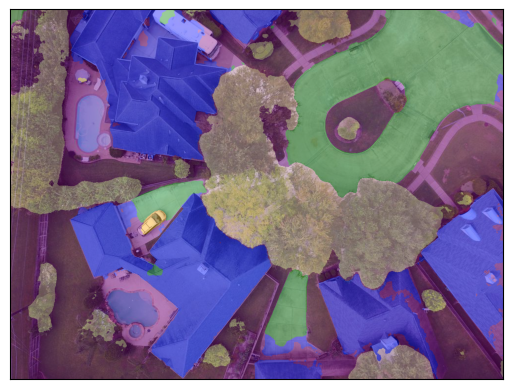

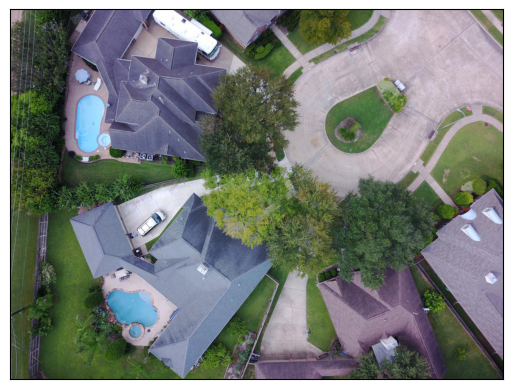

In [43]:
data_path = "tiny-floodnet-challenge"
phase = "test"
index = 9093
orig_image = np.asarray(Image.open(f'{data_path}/{phase}/image/{index}.jpg'))
show_segmentation(orig_image, model)

#### Картинка с большим кол-вом досновных классов (дома, дороги, трава деревья) + мелкие объекты(машины)

По идее машины должны быть оранжевыми

torch.Size([1, 8, 750, 1000])
torch.Size([1, 8, 750, 1000])
torch.Size([1, 3, 750, 1000])


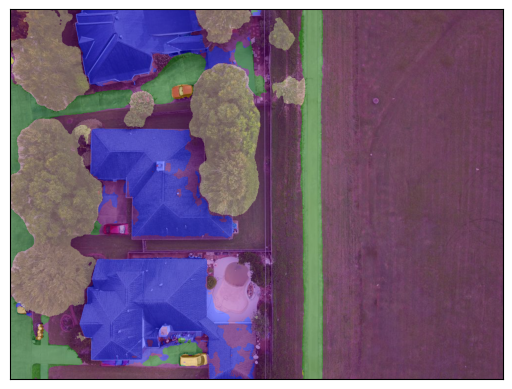

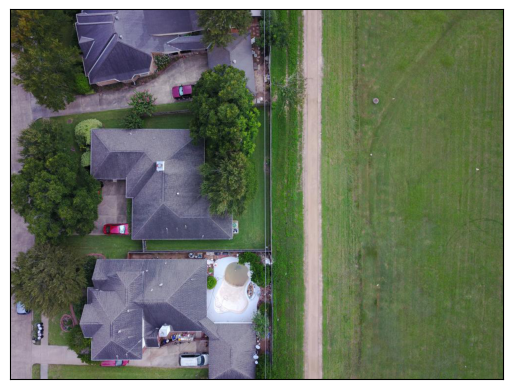

In [44]:
index = 9066
orig_image = np.asarray(Image.open(f'{data_path}/{phase}/image/{index}.jpg'))
show_segmentation(orig_image, model)

#### Картинка с большим кол-вом досновных классов (дома, дороги, трава деревья) + вода

Все бы было хорошо, но иногда вода покрывается дорогой, это, кстати, наблюдается только в последних попытках обучения модели, менее обученный лучше различают воду

torch.Size([1, 8, 750, 1000])
torch.Size([1, 8, 750, 1000])
torch.Size([1, 3, 750, 1000])


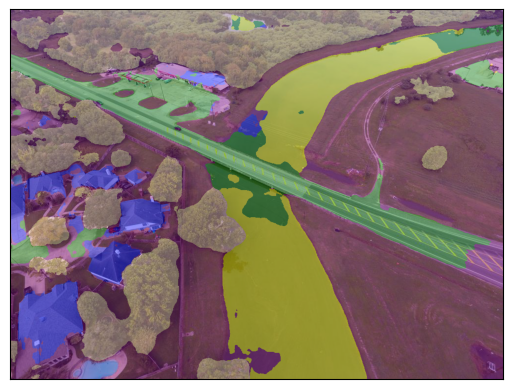

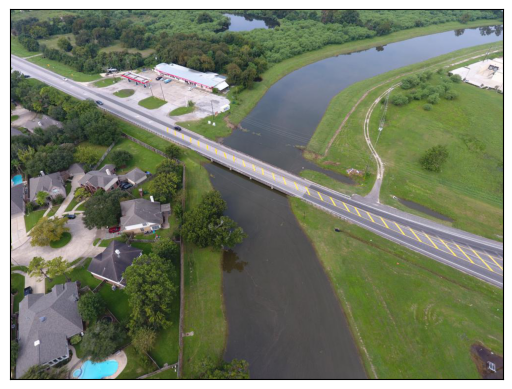

In [45]:
index = 9365
orig_image = np.asarray(Image.open(f'{data_path}/{phase}/image/{index}.jpg'))
show_segmentation(orig_image, model)

#### Картинка с большим кол-вом досновных классов (дома, дороги, трава деревья) + много мелких объектов (машины)

И правда, теперь она умеет отличать здания от воды, а мосты не путает с рекой, трава не смешивается с деревьями.
Мы достигли необходимого результата для основных классов.

torch.Size([1, 8, 750, 1000])
torch.Size([1, 8, 750, 1000])
torch.Size([1, 3, 750, 1000])


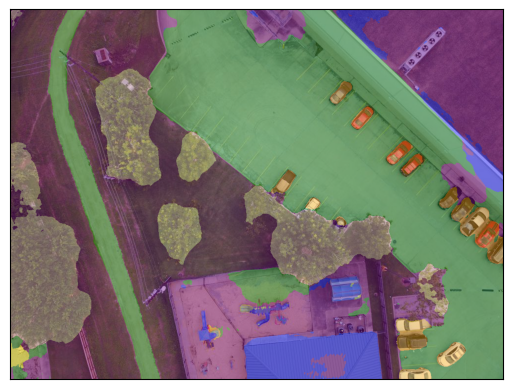

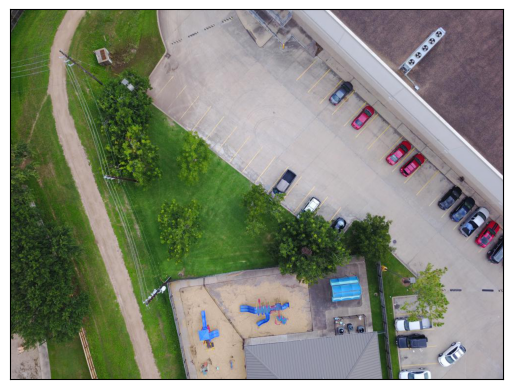

In [46]:
index = 9040
orig_image = np.asarray(Image.open(f'{data_path}/{phase}/image/{index}.jpg'))
show_segmentation(orig_image, model)

Модель так и не научилась распозновать мелкие редко встречающиеся объекты Pool и Vehicle, а т.к. эти классы встречаются редко, то и метрики получаются немного занижена. 
Все остальные классы она умеет хорошо различать, поэтому можно остановится на достигнутом.


Для распознования классов нужно увеличить штраф за них, а для метрик нужно усреднять только по тем, кто встречаются в маске (поэтому были переписаны изначальные метрики и взят nanmean)

Кривые обучения получены с помощью tenorboard и хранятся в папке runs/

In [47]:
%load_ext tensorboard
%tensorboard --logdir runs/

Launching TensorBoard...

Из этих графиков видно, что мы еще не достигли предела по метрикам и можно использовать еще большое кол-во эпох. Я обучал 500 эпох, т.е. всего 1 час